In [ ]:
import numpy as np
import scipy.linalg as la
import time
from numpy.linalg import norm

# Deterministic SVD for rank approximation
def deterministic_rank_approx(A, rank):
    U, s, VT = la.svd(A, full_matrices=False)
    Ar = (U[:, :rank] * s[:rank]) @ VT[:rank, :]
    return Ar

# Randomized SVD for rank approximation
def randomized_rank_approx(A, rank, oversample=5):
    random_matrix = np.random.randn(A.shape[1], rank + oversample)
    Y = A @ random_matrix
    Q, _ = la.qr(Y, mode='economic')
    B = Q.T @ A
    U_hat, s, VT = la.svd(B, full_matrices=False)
    Ar = Q @ (U_hat[:, :rank] * s[:rank]) @ VT[:rank, :]
    return Ar

# RL-based Column Selection (epsilon-greedy)
def rl_column_selection(A, rank, epsilon=0.1):
    m, n = A.shape
    selected_cols = []
    remaining_cols = list(range(n))
    Ar = np.zeros((m, n))

    for _ in range(rank):
        if np.random.rand() < epsilon or not selected_cols:
            col = np.random.choice(remaining_cols)
        else:
            errors = []
            for c in remaining_cols:
                temp_cols = selected_cols + [c]
                Ac = A[:, temp_cols]
                projection = Ac @ la.pinv(Ac) @ A
                errors.append(norm(A - projection, ord='fro'))
            col = remaining_cols[np.argmin(errors)]

        selected_cols.append(col)
        remaining_cols.remove(col)

        Ac = A[:, selected_cols]
        Ar = Ac @ la.pinv(Ac) @ A

    return Ar

# Testing all methods with timing and error reporting
def test_methods():
    np.random.seed(42)
    m, n, true_rank = 100, 80, 10

    # Generate synthetic matrix with known low rank
    A = np.dot(np.random.randn(m, true_rank), np.random.randn(true_rank, n))
    A += 0.01 * np.random.randn(m, n)

    approx_rank = 10

    # Deterministic SVD
    start = time.time()
    Ar_det = deterministic_rank_approx(A, approx_rank)
    print
    time_det = time.time() - start
    err_det = norm(A - Ar_det, 'fro')
    print(f'Deterministic SVD Error: {err_det:.4f}, Time: {time_det:.4f} sec')

    # Randomized SVD
    start = time.time()
    Ar_rand = randomized_rank_approx(A, approx_rank)
    time_rand = time.time() - start
    err_rand = norm(A - Ar_rand, 'fro')
    print(f'Randomized SVD Error: {err_rand:.4f}, Time: {time_rand:.4f} sec')

    # RL-based Column Selection
    start = time.time()
    Ar_rl = rl_column_selection(A, approx_rank, epsilon=0.1)
    time_rl = time.time() - start
    err_rl = norm(A - Ar_rl, 'fro')
    print(f'RL-based Column Selection Error: {err_rl:.4f}, Time: {time_rl:.4f} sec')

if __name__ == '__main__':
    test_methods()

Deterministic SVD Error: 0.7957, Time: 0.0255 sec
Randomized SVD Error: 1.5565, Time: 0.0029 sec
RL-based Column Selection Error: 2.0825, Time: 1.5239 sec


Above code, RL does not have network defined, below we have the one with network.

In [ ]:
import numpy as np
import scipy.linalg as la
import time
from numpy.linalg import norm
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

###############################
# Rank Approximation Functions
###############################

def deterministic_rank_approx(A, rank):
    U, s, VT = la.svd(A, full_matrices=False)
    Ar = (U[:, :rank] * s[:rank]) @ VT[:rank, :]
    return Ar

def randomized_rank_approx(A, rank, oversample=5):
    random_matrix = np.random.randn(A.shape[1], rank + oversample)
    Y = A @ random_matrix
    Q, _ = la.qr(Y, mode='economic')
    B = Q.T @ A
    U_hat, s, VT = la.svd(B, full_matrices=False)
    Ar = Q @ (U_hat[:, :rank] * s[:rank]) @ VT[:rank, :]
    return Ar

#########################################
# RL Environment for Column Selection
#########################################

class ColumnSelectionEnv:
    def __init__(self, A, target_rank):
        self.A = A
        self.target_rank = target_rank
        self.m, self.n = A.shape
        self.reset()

    def reset(self):
        self.selected = []
        self.mask = np.zeros(self.n, dtype=np.float32)
        self.prev_error = norm(self.A, 'fro')
        return self._get_state()

    def _get_state(self):
        return self.mask.copy()

    def step(self, action):
        if self.mask[action] == 1:
            reward = -10.0
            done = True
            return self._get_state(), reward, done

        self.selected.append(action)
        self.mask[action] = 1.0

        Ac = self.A[:, self.selected]
        A_approx = Ac @ la.pinv(Ac) @ self.A
        current_error = norm(self.A - A_approx, 'fro')

        reward = self.prev_error - current_error
        self.prev_error = current_error

        done = len(self.selected) == self.target_rank
        return self._get_state(), reward, done

#########################################
# Deep Q-Network and Agent Definition
#########################################

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        '''
        input dim - dimension of input (state representation)
        output dim - the dimension in which we want output
        hidden dim - This argument determines the number of neurons in the hidden layers of the network (default is 128).
        '''
        super(QNetwork, self).__init__()
        '''
        fc1: A fully connected layer that transforms the input to hidden_dim dimensions
        relu: A ReLU activation function that introduces non-linearity
        fc2: A second fully connected layer from hidden_dim to hidden_dim
        fc3: A third fully connected layer that outputs the final values (typically Q-values for each action)
        '''
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### This is the normal neural network code we write this

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3,
                 gamma=0.99, buffer_size=10000, batch_size=64):
        '''
        What it is: Batch size refers to the number of experiences
        (state, action, reward, next_state, done tuples) that are sampled
        from the replay buffer to update the Q-network's parameters in each training iteration'''
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        '''
        What it is: load_state_dict is a PyTorch function used to load a model's
        parameters (weights and biases) from a state dictionary.
Why it's used:

    Initializing Models: You can use it to initialize a new model with the parameters
    of a pre-trained model.
    Copying Parameters: In your code, it's used to copy the parameters
    of the Q-network to the target network:
    self.target_network.load_state_dict(self.q_network.state_dict()).


        '''
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def select_action(self, state, available_actions, epsilon):
        if random.random() < epsilon:
            return random.choice(available_actions)
        else:
            self.q_network.eval()
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor).cpu().numpy().flatten()
            q_values_masked = np.full_like(q_values, -np.inf)
            q_values_masked[available_actions] = q_values[available_actions]
            action = int(np.argmax(q_values_masked))
            return action

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.q_network(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

#########################################
# Training Loop for the DQN Agent
#########################################

def train_dqn(agent, env, num_episodes=500, epsilon_start=1.0, epsilon_end=0.1,
              epsilon_decay=0.995, target_update_freq=10):
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0.0
        done = False

        while not done:
            available_actions = [i for i, v in enumerate(state) if v == 0]
            action = agent.select_action(state, available_actions, epsilon)
            next_state, reward, done = env.step(action)
            # so this will go till we keep on not selecting any wrong col
            agent.store(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)
        if episode % target_update_freq == 0:
            agent.update_target()

        epsilon = max(epsilon * epsilon_decay, epsilon_end)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.4f}, Epsilon: {epsilon:.4f}")
    return episode_rewards

#########################################
# RL-based Column Selection using DQN
#########################################

def rl_column_selection_with_dqn(A, target_rank, agent):
    env = ColumnSelectionEnv(A, target_rank)
    state = env.reset()
    selected_columns = []
    done = False

    while not done:
        available_actions = [i for i, v in enumerate(state) if v == 0]
        action = agent.select_action(state, available_actions, epsilon=0.0)
        selected_columns.append(action)
        state, reward, done = env.step(action)

    Ac = A[:, selected_columns]
    Ar = Ac @ la.pinv(Ac) @ A
    return Ar, selected_columns

#########################################
# Testing All Methods and Printing Table
#########################################

def test_methods():
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)

    m, n, true_rank = 100, 80, 10

    A = np.dot(np.random.randn(m, true_rank), np.random.randn(true_rank, n))
    A += 0.01 * np.random.randn(m, n)

    approx_rank = 10

    start = time.time()
    Ar_det = deterministic_rank_approx(A, approx_rank)
    time_det = time.time() - start
    err_det = norm(A - Ar_det, 'fro')
    print(f'Deterministic SVD Error: {err_det:.4f}, Time: {time_det:.4f} sec')

    start = time.time()
    Ar_rand = randomized_rank_approx(A, approx_rank)
    time_rand = time.time() - start
    err_rand = norm(A - Ar_rand, 'fro')
    print(f'Randomized SVD Error: {err_rand:.4f}, Time: {time_rand:.4f} sec')

    env = ColumnSelectionEnv(A, approx_rank)
    state_dim = env.n
    action_dim = env.n
    agent = DQNAgent(state_dim, action_dim, hidden_dim=128, lr=1e-3,
                     gamma=0.99, buffer_size=5000, batch_size=64)
    print("Training DQN agent for RL-based column selection...")
    train_dqn(agent, env, num_episodes=500, epsilon_start=1.0, epsilon_end=0.1)

    start = time.time()
    Ar_rl, selected_columns = rl_column_selection_with_dqn(A, approx_rank, agent)
    time_rl = time.time() - start
    err_rl = norm(A - Ar_rl, 'fro')
    print(f'RL-based Column Selection (DQN) Error: {err_rl:.4f}, Time: {time_rl:.4f} sec')
    print("Selected columns:", selected_columns)

    # Print a properly aligned GitHub-style markdown table.
    header = "| {:<35} | {:>10} | {:>12} |".format("Method", "Error", "Time (sec)")
    divider = "|{:-<37}|{:-<12}|{:-<14}|".format("", "", "")
    row1 = "| {:<35} | {:>10.4f} | {:>12.4f} |".format("Deterministic SVD", err_det, time_det)
    row2 = "| {:<35} | {:>10.4f} | {:>12.4f} |".format("Randomized SVD", err_rand, time_rand)
    row3 = "| {:<35} | {:>10.4f} | {:>12.4f} |".format("RL-based Column Selection (DQN)", err_rl, time_rl)

    print("\n" + header)
    print(divider)
    print(row1)
    print(row2)
    print(row3)

if __name__ == '__main__':
    test_methods()


Deterministic SVD Error: 0.7957, Time: 0.0122 sec
Randomized SVD Error: 1.5565, Time: 0.0361 sec
Training DQN agent for RL-based column selection...


<ipython-input-2-e0d2a3c60b50>:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(self.device)


Episode 50/500, Total Reward: 267.7273, Epsilon: 0.7783
Episode 100/500, Total Reward: 270.0884, Epsilon: 0.6058
Episode 150/500, Total Reward: 268.9512, Epsilon: 0.4715
Episode 200/500, Total Reward: 271.6007, Epsilon: 0.3670
Episode 250/500, Total Reward: 202.2233, Epsilon: 0.2856
Episode 300/500, Total Reward: 264.7285, Epsilon: 0.2223
Episode 350/500, Total Reward: 270.5771, Epsilon: 0.1730
Episode 400/500, Total Reward: 268.5931, Epsilon: 0.1347
Episode 450/500, Total Reward: 270.8890, Epsilon: 0.1048
Episode 500/500, Total Reward: 271.9652, Epsilon: 0.1000
RL-based Column Selection (DQN) Error: 3.1676, Time: 0.0246 sec
Selected columns: [32, 43, 47, 39, 28, 24, 15, 26, 58, 70]

| Method                              |      Error |   Time (sec) |
|-------------------------------------|------------|--------------|
| Deterministic SVD                   |     0.7957 |       0.0122 |
| Randomized SVD                      |     1.5565 |       0.0361 |
| RL-based Column Selection (DQN)  

In [ ]:
import numpy as np
import scipy.linalg as la
import time
from numpy.linalg import norm
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

###############################
# Rank Approximation Functions
###############################

def deterministic_rank_approx(A, rank):
    U, s, VT = la.svd(A, full_matrices=False)
    Ar = (U[:, :rank] * s[:rank]) @ VT[:rank, :]
    return Ar

def randomized_rank_approx(A, rank, oversample=5, n_iter=2, return_components=False):
    """
    Enhanced randomized SVD with power iteration

    Parameters:
    -----------
    A : numpy array
        Input matrix
    rank : int
        Target rank
    oversample : int
        Oversampling parameter
    n_iter : int
        Number of power iterations
    return_components : bool
        If True, return decomposition components

    Returns:
    --------
    Ar or (U, s, VT) : numpy array or tuple
        Rank-k approximation or components
    """
    m, n = A.shape
    random_matrix = np.random.randn(n, rank + oversample)
    Y = A @ random_matrix

    # Power iteration to improve accuracy
    for _ in range(n_iter):
        Y = A @ (A.T @ Y)

    Q, _ = la.qr(Y, mode='economic')
    B = Q.T @ A
    U_hat, s, VT = la.svd(B, full_matrices=False)
    U = Q @ U_hat

    if return_components:
        return U, s, VT
    else:
        Ar = (U[:, :rank] * s[:rank]) @ VT[:rank, :]
        return Ar

def cur_decomposition(A, rank, oversample=5):
    """
    CUR decomposition for low-rank approximation

    Parameters:
    -----------
    A : numpy array
        Input matrix
    rank : int
        Target rank
    oversample : int
        Oversampling parameter

    Returns:
    --------
    Ar : numpy array
        Rank-k approximation of A
    cols : list
        Indices of selected columns
    rows : list
        Indices of selected rows
    """
    m, n = A.shape

    # Step 1: Compute approximate SVD
    U, s, VT = randomized_rank_approx(A, rank, oversample, return_components=True)

    # Step 2: Compute column leverage scores
    col_lev = np.sum(VT[:rank, :]**2, axis=0)
    col_lev = col_lev / np.sum(col_lev)

    # Step 3: Sample columns
    c = min(rank * 3, n)
    col_indices = np.random.choice(n, size=c, replace=False, p=col_lev)
    C = A[:, col_indices]

    # Step 4: Compute row leverage scores
    row_lev = np.sum(U[:, :rank]**2, axis=1)
    row_lev = row_lev / np.sum(row_lev)

    # Step 5: Sample rows
    r = min(rank * 3, m)
    row_indices = np.random.choice(m, size=r, replace=False, p=row_lev)
    R = A[row_indices, :]

    # Step 6: Compute intersection matrix
    U = A[row_indices, :][:, col_indices]
    U_pinv = la.pinv(U)

    # Step 7: Form the approximation
    Ar = C @ U_pinv @ R

    return Ar, col_indices, row_indices

def evaluate_approximation(A, Ar, metrics=None):
    """
    Evaluate matrix approximation with multiple metrics

    Parameters:
    -----------
    A : numpy array
        Original matrix
    Ar : numpy array
        Approximated matrix
    metrics : list of str
        Metrics to compute: 'frobenius', 'spectral', 'nuclear'

    Returns:
    --------
    results : dict
        Dictionary containing error metrics
    """
    if metrics is None:
        metrics = ['frobenius']

    results = {}
    error = A - Ar

    if 'frobenius' in metrics:
        results['frobenius'] = norm(error, 'fro') / norm(A, 'fro')

    if 'spectral' in metrics:
        results['spectral'] = norm(error, 2) / norm(A, 2)

    if 'nuclear' in metrics:
        s_error = la.svd(error, compute_uv=False)
        s_orig = la.svd(A, compute_uv=False)
        results['nuclear'] = sum(s_error) / sum(s_orig)

    if 'rank' in metrics:
        s_approx = la.svd(Ar, compute_uv=False)
        results['effective_rank'] = sum(s_approx > 1e-10)

    return results

def adaptive_rank_selection(A, tol=1e-3, max_rank=None, method='randomized'):
    """
    Adaptively select rank based on approximation error

    Parameters:
    -----------
    A : numpy array
        Input matrix
    tol : float
        Error tolerance
    max_rank : int
        Maximum rank to consider
    method : str
        Approximation method ('deterministic' or 'randomized')

    Returns:
    --------
    selected_rank : int
        Selected rank
    """
    m, n = A.shape
    if max_rank is None:
        max_rank = min(m, n) // 2

    norm_A = norm(A, 'fro')

    for r in range(1, max_rank + 1):
        if method == 'deterministic':
            Ar = deterministic_rank_approx(A, r)
        else:
            Ar = randomized_rank_approx(A, r)

        rel_error = norm(A - Ar, 'fro') / norm_A
        if rel_error < tol:
            return r

    return max_rank

#########################################
# Enhanced RL Environment for Column Selection
#########################################

class EnhancedColumnSelectionEnv:
    def __init__(self, A, target_rank, state_type='mask', reward_type='error_reduction',
                 early_stopping=True, early_stopping_threshold=1e-4, max_steps=None):
        """
        Enhanced environment for column selection with improved state representation and reward mechanisms

        Parameters:
        -----------
        A : numpy array
            Input matrix
        target_rank : int
            Target number of columns to select
        state_type : str
            Type of state representation ('mask', 'correlation', 'leverage', 'combined')
        reward_type : str
            Type of reward function ('error_reduction', 'normalized', 'spectral', 'combined')
        early_stopping : bool
            Whether to enable early stopping
        early_stopping_threshold : float
            Threshold for early stopping
        max_steps : int
            Maximum number of steps (defaults to target_rank)
        """
        self.A = A
        self.target_rank = target_rank
        self.m, self.n = A.shape
        self.state_type = state_type
        self.reward_type = reward_type
        self.early_stopping = early_stopping
        self.early_stopping_threshold = early_stopping_threshold
        self.max_steps = max_steps if max_steps else target_rank

        # Precompute leverage scores for state representation
        if state_type in ['leverage', 'combined']:
            U, _, _ = randomized_rank_approx(A, min(target_rank*2, min(self.m, self.n)),
                                           return_components=True)
            self.leverage_scores = np.sum(U**2, axis=1)
            self.leverage_scores = self.leverage_scores / np.sum(self.leverage_scores)

        # Precompute column correlations for state representation
        if state_type in ['correlation', 'combined']:
            A_normalized = A / norm(A, axis=0, keepdims=True)
            self.column_correlations = A_normalized.T @ A_normalized

        self.reset()

    def reset(self):
        self.selected = []
        self.mask = np.zeros(self.n, dtype=np.float32)
        self.steps = 0
        self.initial_error = norm(self.A, 'fro')
        self.prev_error = self.initial_error
        self.best_error = self.initial_error
        return self._get_state()

    def _get_state(self):
        """Enhanced state representation based on configuration"""
        if self.state_type == 'mask':
            return self.mask.copy()

        elif self.state_type == 'correlation':
            # Include correlation information with selected columns
            if not self.selected:
                return np.zeros(self.n, dtype=np.float32)

            # Average correlation with already selected columns
            state = np.zeros(self.n, dtype=np.float32)
            for i in range(self.n):
                if self.mask[i] == 0:  # Only for unselected columns
                    correlations = [abs(self.column_correlations[i, j]) for j in self.selected]
                    state[i] = np.mean(correlations)
            return state

        elif self.state_type == 'leverage':
            # Combine mask with leverage scores
            state = np.zeros(self.n, dtype=np.float32)
            for i in range(self.n):
                if self.mask[i] == 0:  # Only for unselected columns
                    state[i] = self.leverage_scores[i]
            return state

        elif self.state_type == 'combined':
            # Combine mask, correlation and leverage information
            state = np.zeros((self.n, 3), dtype=np.float32)

            # First channel: binary mask (0 for available, 1 for selected)
            state[:, 0] = self.mask

            # Second channel: leverage scores for unselected columns
            for i in range(self.n):
                if self.mask[i] == 0:
                    state[i, 1] = self.leverage_scores[i]

            # Third channel: average correlation with selected columns
            if self.selected:
                for i in range(self.n):
                    if self.mask[i] == 0:
                        correlations = [abs(self.column_correlations[i, j]) for j in self.selected]
                        state[i, 2] = np.mean(correlations)

            return state.reshape(-1)  # Flatten for compatibility with networks

        else:
            raise ValueError(f"Unknown state type: {self.state_type}")

    def step(self, action):
        # Check if action is valid (column not already selected)
        if self.mask[action] == 1:
            reward = -10.0  # Penalty for selecting already chosen column
            done = True
            return self._get_state(), reward, done, {"error": self.prev_error}

        # Add column to selection
        self.selected.append(action)
        self.mask[action] = 1.0
        self.steps += 1

        # Compute approximation and error
        Ac = self.A[:, self.selected]
        A_approx = Ac @ la.pinv(Ac) @ self.A
        current_error = norm(self.A - A_approx, 'fro')

        # Track best error
        if current_error < self.best_error:
            self.best_error = current_error

        # Compute reward based on configured type
        if self.reward_type == 'error_reduction':
            reward = self.prev_error - current_error

        elif self.reward_type == 'normalized':
            # Normalized by initial error for more stable training
            reward = (self.prev_error - current_error) / self.initial_error

        elif self.reward_type == 'spectral':
            # Using spectral norm which can be more sensitive to structure
            prev_spectral_error = norm(self.A - Ac[:, :-1] @ la.pinv(Ac[:, :-1]) @ self.A, 2)
            current_spectral_error = norm(self.A - A_approx, 2)
            reward = prev_spectral_error - current_spectral_error

        elif self.reward_type == 'combined':
            # Combination of error reduction and computation efficiency
            error_reduction = self.prev_error - current_error
            norm_reduction = error_reduction / self.initial_error

            # Small bonus for selecting columns that reduce error efficiently
            efficiency_bonus = 0.0
            if len(self.selected) > 1:
                expected_reduction = self.initial_error / self.target_rank
                if error_reduction > expected_reduction:
                    efficiency_bonus = 0.1

            reward = norm_reduction + efficiency_bonus

            # Penalty for minimal improvement
            if error_reduction < self.early_stopping_threshold * self.initial_error:
                reward *= 0.5
        else:
            raise ValueError(f"Unknown reward type: {self.reward_type}")

        # Update previous error for next iteration
        self.prev_error = current_error

        # Check termination conditions
        done = False
        info = {"error": current_error, "relative_error": current_error / self.initial_error}

        # Target rank reached
        if len(self.selected) >= self.target_rank:
            done = True

        # Early stopping condition
        elif self.early_stopping and current_error < self.early_stopping_threshold * self.initial_error:
            done = True
            info["early_stopped"] = True

        # Maximum steps reached
        elif self.steps >= self.max_steps:
            done = True
            info["max_steps_reached"] = True

        return self._get_state(), reward, done, info

#########################################
# Advanced Actor-Critic RL Agent for Column Selection
#########################################

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()

        # Shared feature extraction layers
        self.feature_extraction = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Actor head (policy network)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic head (value network)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        features = self.feature_extraction(x)
        action_probs = self.actor(features)
        state_value = self.critic(features)
        return action_probs, state_value

class A2CAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=3e-4, gamma=0.99, entropy_weight=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.entropy_weight = entropy_weight
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = ActorCritic(state_dim, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # For logging and debugging
        self.actor_losses = []
        self.critic_losses = []
        self.entropy_losses = []
        self.total_losses = []

    def select_action(self, state, available_actions, training=True):
        self.model.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        with torch.no_grad():
            action_probs, _ = self.model(state_tensor)
            action_probs = action_probs.squeeze().cpu().numpy()

        # Mask unavailable actions
        masked_probs = np.zeros_like(action_probs)
        masked_probs[available_actions] = action_probs[available_actions]

        # Normalize probabilities
        if np.sum(masked_probs) > 0:
            masked_probs = masked_probs / np.sum(masked_probs)
        else:
            masked_probs[available_actions] = 1.0 / len(available_actions)

        if training:
            # Sample action according to the probability during training
            action = np.random.choice(len(masked_probs), p=masked_probs)
        else:
            # Take most likely action during evaluation
            if np.max(masked_probs) > 0:
                action = np.argmax(masked_probs)
            else:
                action = np.random.choice(available_actions)

        return action

    def update(self, states, actions, rewards, next_states, dones):
        self.model.train()

        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Get current action probabilities and state values
        action_probs, state_values = self.model(states)
        state_values = state_values.squeeze()

        # Get next state values for bootstrapping
        with torch.no_grad():
            _, next_state_values = self.model(next_states)
            next_state_values = next_state_values.squeeze()

        # Compute advantages and TD targets
        td_targets = rewards + self.gamma * next_state_values * (1 - dones)
        advantages = td_targets - state_values

        # Select probabilities corresponding to actions taken
        selected_action_probs = action_probs.gather(1, actions.unsqueeze(1)).squeeze()

        # Compute losses
        critic_loss = advantages.pow(2).mean()
        actor_loss = -(torch.log(selected_action_probs + 1e-10) * advantages.detach()).mean()

        # Entropy regularization to encourage exploration
        entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=1).mean()
        entropy_loss = -self.entropy_weight * entropy

        # Total loss
        total_loss = actor_loss + critic_loss + entropy_loss

        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        # Log losses
        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())
        self.entropy_losses.append(entropy_loss.item())
        self.total_losses.append(total_loss.item())

        return {
            'actor_loss': actor_loss.item(),
            'critic_loss': critic_loss.item(),
            'entropy': entropy.item(),
            'total_loss': total_loss.item()
        }

#########################################
# Training Function for A2C Agent
#########################################

def train_a2c(agent, env, num_episodes=500, max_steps_per_episode=None):
    """
    Train an A2C agent for column selection

    Parameters:
    -----------
    agent : A2CAgent
        The agent to train
    env : EnhancedColumnSelectionEnv
        The environment
    num_episodes : int
        Number of episodes to train
    max_steps_per_episode : int
        Maximum steps per episode (defaults to env.target_rank)

    Returns:
    --------
    episode_rewards : list
        List of rewards per episode
    training_info : dict
        Dictionary containing training metrics
    """
    if max_steps_per_episode is None:
        max_steps_per_episode = env.target_rank

    episode_rewards = []
    episode_errors = []
    episode_steps = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        step = 0

        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []

        while not done and step < max_steps_per_episode:
            available_actions = [i for i, v in enumerate(env.mask) if v == 0]
            action = agent.select_action(state, available_actions, training=True)

            next_state, reward, done, info = env.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

            state = next_state
            total_reward += reward
            step += 1

            # Update policy every step for online learning
            if len(states) >= 1:
                agent.update(states, actions, rewards, next_states, dones)
                states, actions, rewards, next_states, dones = [], [], [], [], []

        # Log episode metrics
        episode_rewards.append(total_reward)
        episode_errors.append(env.prev_error / env.initial_error)
        episode_steps.append(step)

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Reward: {total_reward:.4f}, " +
                  f"Error: {env.prev_error / env.initial_error:.4f}, Steps: {step}")

    training_info = {
        'episode_rewards': episode_rewards,
        'episode_errors': episode_errors,
        'episode_steps': episode_steps,
        'actor_losses': agent.actor_losses,
        'critic_losses': agent.critic_losses,
        'entropy_losses': agent.entropy_losses
    }

    return episode_rewards, training_info

#########################################
# Column Selection using the A2C Agent
#########################################

def rl_column_selection_with_a2c(A, target_rank, agent, state_type='combined',
                                reward_type='combined', early_stopping=True):
    """
    Select columns using a trained A2C agent

    Parameters:
    -----------
    A : numpy array
        Input matrix
    target_rank : int
        Target number of columns to select
    agent : A2CAgent
        Trained agent
    state_type : str
        State representation type for environment
    reward_type : str
        Reward function type for environment
    early_stopping : bool
        Whether to use early stopping

    Returns:
    --------
    Ar : numpy array
        Approximated matrix
    selected_columns : list
        Indices of selected columns
    info : dict
        Additional information
    """
    env = EnhancedColumnSelectionEnv(
        A,
        target_rank,
        state_type=state_type,
        reward_type=reward_type,
        early_stopping=early_stopping
    )

    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        available_actions = [i for i, v in enumerate(env.mask) if v == 0]
        action = agent.select_action(state, available_actions, training=False)
        state, reward, done, info = env.step(action)
        total_reward += reward

    # Get the selected columns and compute the approximation
    selected_columns = env.selected
    Ac = A[:, selected_columns]
    Ar = Ac @ la.pinv(Ac) @ A

    info['total_reward'] = total_reward
    info['num_columns'] = len(selected_columns)
    info['relative_error'] = info['error'] / env.initial_error

    return Ar, selected_columns, info

#########################################
# Enhanced Experimental Framework
#########################################

def generate_test_matrix(m, n, rank, matrix_type='low_rank_noise', noise_level=0.01, condition_number=None):
    """
    Generate test matrices with different characteristics

    Parameters:
    -----------
    m, n : int
        Matrix dimensions
    rank : int
        Target rank
    matrix_type : str
        Type of matrix to generate:
        - 'low_rank_noise': Low rank matrix with added noise
        - 'exp_decay': Matrix with exponentially decaying singular values
        - 'clustered': Matrix with clustered singular values
        - 'ill_conditioned': Matrix with high condition number
    noise_level : float
        Level of noise to add
    condition_number : float
        Condition number for ill-conditioned matrices

    Returns:
    --------
    A : numpy array
        Generated matrix
    """
    if matrix_type == 'low_rank_noise':
        # Basic low rank matrix with noise
        U = np.random.randn(m, rank)
        V = np.random.randn(rank, n)
        A = U @ V ### Clearly A will have at most rank = rank as we are now scaling the rank level
        ### cols of U with the cols of V to get the result
        A += noise_level * np.random.randn(m, n) * np.linalg.norm(A, 'fro') / np.sqrt(m*n)

    elif matrix_type == 'exp_decay':
        # Matrix with exponentially decaying singular values
        U = np.random.randn(m, min(m, n))
        U, _ = np.linalg.qr(U)
        V = np.random.randn(min(m, n), n)
        V, _ = np.linalg.qr(V.T)
        V = V.T

        # Create exponentially decaying singular values
        s = np.exp(-np.arange(min(m, n)) / (rank/3))
        A = U @ np.diag(s) @ V
        A += noise_level * np.random.randn(m, n) * np.linalg.norm(A, 'fro') / np.sqrt(m*n)

    elif matrix_type == 'clustered':
        # Matrix with clustered singular values
        U = np.random.randn(m, min(m, n))
        U, _ = np.linalg.qr(U)
        V = np.random.randn(min(m, n), n)
        V, _ = np.linalg.qr(V.T)
        V = V.T

        # Create clustered singular values
        s = np.ones(min(m, n))
        s[:rank//2] = 100  # First cluster
        s[rank//2:rank] = 10   # Second cluster
        s[rank:] = 1   # Background
        A = U @ np.diag(s) @ V
        A += noise_level * np.random.randn(m, n) * np.linalg.norm(A, 'fro') / np.sqrt(m*n)

    elif matrix_type == 'ill_conditioned':
        # Ill-conditioned matrix
        U = np.random.randn(m, rank)
        U, _ = np.linalg.qr(U)
        V = np.random.randn(rank, n)
        V, _ = np.linalg.qr(V.T)
        V = V.T

        # Create singular values with specified condition number
        if condition_number is None:
            condition_number = 1e4

        s = np.linspace(condition_number, 1, rank)
        A = U @ np.diag(s) @ V
        A += noise_level * np.random.randn(m, n) * np.linalg.norm(A, 'fro') / np.sqrt(m*n)

    else:
        raise ValueError(f"Unknown matrix type: {matrix_type}")

    return A

def comprehensive_method_comparison(matrices, target_ranks, methods, metrics=None):
    """
    Comprehensive comparison of approximation methods

    Parameters:
    -----------
    matrices : dict
        Dictionary of test matrices {name: matrix}
    target_ranks : list
        List of target ranks to test
    methods : dict
        Dictionary of methods to compare {name: method_function}
    metrics : list
        List of metrics to compute

    Returns:
    --------
    results : dict
        Nested dictionary with all results
    """
    if metrics is None:
        metrics = ['frobenius', 'spectral', 'time']

    results = {}

    for matrix_name, A in matrices.items():
        results[matrix_name] = {}

        for rank in target_ranks:
            results[matrix_name][rank] = {}

            for method_name, method_fn in methods.items():
                print(f"Testing {method_name} on {matrix_name} with rank {rank}")

                # Time the method
                start_time = time.time()
                info = {}

                if method_name.startswith('RL'):
                    # Handle RL methods that might return different numbers of values
                    try:
                        # First try to get 3 return values
                        Ar, selected_columns, rl_info = method_fn(A, rank)
                        info.update(rl_info)
                    except ValueError:
                        try:
                            # If that fails, try to get 2 return values
                            Ar, selected_columns = method_fn(A, rank)
                        except ValueError:
                            # If that fails, just get the approximation
                            Ar = method_fn(A, rank)
                            selected_columns = []

                    info['num_columns'] = len(selected_columns)
                else:
                    # Non-RL methods
                    Ar = method_fn(A, rank)
                    selected_columns = []

                elapsed_time = time.time() - start_time

                # Store results
                method_results = {'time': elapsed_time}

                # Calculate requested metrics
                error_metrics = evaluate_approximation(A, Ar, metrics)
                method_results.update(error_metrics)
                method_results.update(info)

                results[matrix_name][rank][method_name] = method_results

    return results

def format_results_table(results, metric='frobenius', matrix_names=None, methods=None, ranks=None):
    """
    Format results as a Markdown table

    Parameters:
    -----------
    results : dict
        Results from comprehensive_method_comparison
    metric : str
        Metric to display in the table
    matrix_names : list
        Names of matrices to include (None for all)
    methods : list
        Names of methods to include (None for all)
    ranks : list
        Ranks to include (None for all)

    Returns:
    --------
    table : str
        Markdown table
    """
    if matrix_names is None:
        matrix_names = list(results.keys())

    if ranks is None:
        # Find all unique ranks across matrices
        ranks = set()
        for matrix_name in results:
            ranks.update(results[matrix_name].keys())
        ranks = sorted(list(ranks))

    # Create header
    header = "| Matrix | Rank |"
    for method in methods:
        header += f" {method} |"

    # Create divider
    divider = "|-------|------|"
    for _ in methods:
        divider += "-------|"

    rows = []

    for matrix_name in matrix_names:
        for rank in ranks:
            if rank not in results[matrix_name]:
                continue

            row = f"| {matrix_name} | {rank} |"

            for method in methods:
                if method in results[matrix_name][rank]:
                    value = results[matrix_name][rank][method][metric]
                    row += f" {value:.4f} |"
                else:
                    row += " N/A |"

            rows.append(row)

    return header + "\n" + divider + "\n" + "\n".join(rows)



#########################################
# Sir's CODE
#########################################

#########################################
# Deep Q-Network and Agent Definition
#########################################

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3,
                 gamma=0.99, buffer_size=10000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def select_action(self, state, available_actions, epsilon):
        if random.random() < epsilon:
            return random.choice(available_actions)
        else:
            self.q_network.eval()
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor).cpu().numpy().flatten()
            q_values_masked = np.full_like(q_values, -np.inf)
            q_values_masked[available_actions] = q_values[available_actions]
            action = int(np.argmax(q_values_masked))
            return action

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.q_network(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

#########################################
# Training Loop for the DQN Agent
#########################################

def train_dqn(agent, env, num_episodes=500, epsilon_start=1.0, epsilon_end=0.1,
              epsilon_decay=0.995, target_update_freq=10):
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0.0
        done = False

        while not done:
            available_actions = [i for i, v in enumerate(state) if v == 0]
            action = agent.select_action(state, available_actions, epsilon)
            next_state, reward, done = env.step(action)
            agent.store(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)
        if episode % target_update_freq == 0:
            agent.update_target()

        epsilon = max(epsilon * epsilon_decay, epsilon_end)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.4f}, Epsilon: {epsilon:.4f}")
    return episode_rewards

#########################################
# RL-based Column Selection using DQN
#########################################

def rl_column_selection_with_dqn(A, target_rank, agent):
    env = ColumnSelectionEnv(A, target_rank)
    state = env.reset()
    selected_columns = []
    # total_reward = 0
    done = False

    while not done:
        available_actions = [i for i, v in enumerate(state) if v == 0]
        action = agent.select_action(state, available_actions, epsilon=0.0)
        selected_columns.append(action)
        state, reward, done = env.step(action)
        # total_reward += reward

    Ac = A[:, selected_columns]
    Ar = Ac @ la.pinv(Ac) @ A


    return Ar, selected_columns

#########################################
# Testing All Methods and Printing Table
#########################################

def test_methods():
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)

    m, n, true_rank = 100, 80, 10

    A = np.dot(np.random.randn(m, true_rank), np.random.randn(true_rank, n))
    A += 0.01 * np.random.randn(m, n)

    approx_rank = 10

    start = time.time()
    Ar_det = deterministic_rank_approx(A, approx_rank)
    time_det = time.time() - start
    err_det = norm(A - Ar_det, 'fro')
    print(f'Deterministic SVD Error: {err_det:.4f}, Time: {time_det:.4f} sec')

    start = time.time()
    Ar_rand = randomized_rank_approx(A, approx_rank)
    time_rand = time.time() - start
    err_rand = norm(A - Ar_rand, 'fro')
    print(f'Randomized SVD Error: {err_rand:.4f}, Time: {time_rand:.4f} sec')

    env = ColumnSelectionEnv(A, approx_rank)
    state_dim = env.n
    action_dim = env.n
    agent = DQNAgent(state_dim, action_dim, hidden_dim=128, lr=1e-3,
                     gamma=0.99, buffer_size=5000, batch_size=64)
    print("Training DQN agent for RL-based column selection...")
    train_dqn(agent, env, num_episodes=500, epsilon_start=1.0, epsilon_end=0.1)

    start = time.time()
    Ar_rl, selected_columns = rl_column_selection_with_dqn(A, approx_rank, agent)
    time_rl = time.time() - start
    err_rl = norm(A - Ar_rl, 'fro')
    print(f'RL-based Column Selection (DQN) Error: {err_rl:.4f}, Time: {time_rl:.4f} sec')
    print("Selected columns:", selected_columns)

    # Print a properly aligned GitHub-style markdown table.
    header = "| {:<35} | {:>10} | {:>12} |".format("Method", "Error", "Time (sec)")
    divider = "|{:-<37}|{:-<12}|{:-<14}|".format("", "", "")
    row1 = "| {:<35} | {:>10.4f} | {:>12.4f} |".format("Deterministic SVD", err_det, time_det)
    row2 = "| {:<35} | {:>10.4f} | {:>12.4f} |".format("Randomized SVD", err_rand, time_rand)
    row3 = "| {:<35} | {:>10.4f} | {:>12.4f} |".format("RL-based Column Selection (DQN)", err_rl, time_rl)

    print("\n" + header)
    print(divider)
    print(row1)
    print(row2)
    print(row3)

if __name__ == '__main__':
    test_methods()

#########################################
# RL Environment for Column Selection
#########################################

class ColumnSelectionEnv:
    def __init__(self, A, target_rank):
        self.A = A
        self.target_rank = target_rank
        self.m, self.n = A.shape
        self.reset()

    def reset(self):
        self.selected = []
        self.mask = np.zeros(self.n, dtype=np.float32)
        self.prev_error = norm(self.A, 'fro')
        return self._get_state()

    def _get_state(self):
        return self.mask.copy()

    def step(self, action):
        if self.mask[action] == 1:
            reward = -10.0
            done = True
            return self._get_state(), reward, done

        self.selected.append(action)
        self.mask[action] = 1.0

        Ac = self.A[:, self.selected]
        A_approx = Ac @ la.pinv(Ac) @ self.A
        current_error = norm(self.A - A_approx, 'fro')

        reward = self.prev_error - current_error
        self.prev_error = current_error

        done = len(self.selected) == self.target_rank
        return self._get_state(), reward, done

#########################################
# Environment Wrapper for Compatibility
#########################################

class EnhancedColumnSelectionWrapper:
    """Wrapper to make ColumnSelectionEnv compatible with A2C training"""
    def __init__(self, env):
        self.env = env
        self.n = env.n
        self.A = env.A
        self.target_rank = env.target_rank
        self.initial_error = norm(self.A, 'fro')
        self.mask = env.mask
        self.selected = env.selected
        self.prev_error = env.prev_error

    def reset(self):
        state = self.env.reset()
        self.mask = self.env.mask
        self.selected = self.env.selected
        self.prev_error = self.env.prev_error
        return state

    def step(self, action):
        state, reward, done = self.env.step(action)
        self.mask = self.env.mask
        self.selected = self.env.selected
        self.prev_error = self.env.prev_error

        # Adapt return format to match EnhancedColumnSelectionEnv (add info dict)
        return state, reward, done, {
            "error": self.prev_error,
            "relative_error": self.prev_error / self.initial_error
        }

Deterministic SVD Error: 0.7957, Time: 0.1201 sec
Randomized SVD Error: 0.7957, Time: 0.0014 sec
Training DQN agent for RL-based column selection...
Episode 50/500, Total Reward: 267.7273, Epsilon: 0.7783
Episode 100/500, Total Reward: 270.0884, Epsilon: 0.6058
Episode 150/500, Total Reward: 268.9512, Epsilon: 0.4715
Episode 200/500, Total Reward: 271.6007, Epsilon: 0.3670
Episode 250/500, Total Reward: 202.2233, Epsilon: 0.2856
Episode 300/500, Total Reward: 264.7285, Epsilon: 0.2223
Episode 350/500, Total Reward: 270.5771, Epsilon: 0.1730
Episode 400/500, Total Reward: 268.5931, Epsilon: 0.1347
Episode 450/500, Total Reward: 270.8890, Epsilon: 0.1048
Episode 500/500, Total Reward: 271.9652, Epsilon: 0.1000
RL-based Column Selection (DQN) Error: 3.1676, Time: 0.0081 sec
Selected columns: [32, 43, 47, 39, 28, 24, 15, 26, 58, 70]

| Method                              |      Error |   Time (sec) |
|-------------------------------------|------------|--------------|
| Deterministic SVD   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm
import os
import pickle

os.makedirs("models", exist_ok=True)
os.makedirs("plot",exist_ok=True)
os.makedirs("results",exist_ok=True)
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""
    import random
    import torch

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)



In [ ]:
def train_matrix_size_models():
    """Train and save RL models for different matrix sizes"""
    import os
    os.makedirs("models", exist_ok=True)  # Ensure directory exists
    sizes = [(100, 80), (200, 160), (400, 320), (800, 640)]
    true_rank = 10
    target_rank = 10

    for m, n in sizes:
        print(f"\n🔧 Training agents for matrix size {m}x{n}")
        A = generate_test_matrix(m, n, true_rank, 'low_rank_noise')

        # Only train for smaller matrices
        if m <= 400 or True:
            # --- DQN Agent ---
            env = ColumnSelectionEnv(A, target_rank)
            state_dim = env.n
            action_dim = env.n
            dqn_agent = DQNAgent(state_dim, action_dim)
            print(f"🧠 Training DQN agent for {m}x{n} matrix...")
            train_dqn(dqn_agent, env, num_episodes=300)

            # Save DQN agent
            dqn_path = f"models/dqn_model_{m}x{n}.pt"
            torch.save(dqn_agent.q_network.state_dict(), dqn_path)
            print(f"✅ DQN model saved to {dqn_path}")

            # --- A2C Agent ---
            env = EnhancedColumnSelectionEnv(A, target_rank, state_type='combined', reward_type='combined')
            state_dim = env.n * 3 if env.state_type == 'combined' else env.n
            action_dim = env.n
            a2c_agent = A2CAgent(state_dim, action_dim)
            print(f"🧠 Training A2C agent for {m}x{n} matrix...")
            train_a2c(a2c_agent, env, num_episodes=300)

            # Save A2C agent - Fix: Save the whole model instead of separate actor/critic
            a2c_model_path = f"models/a2c_model_{m}x{n}.pt"
            torch.save(a2c_agent.model.state_dict(), a2c_model_path)
            print(f"✅ A2C model saved to {a2c_model_path}")

# Run the training
train_matrix_size_models()


🔧 Training agents for matrix size 100x80
🧠 Training DQN agent for 100x80 matrix...
Episode 50/300, Total Reward: 269.3891, Epsilon: 0.7783
Episode 100/300, Total Reward: 264.9161, Epsilon: 0.6058
Episode 150/300, Total Reward: 230.5629, Epsilon: 0.4715
Episode 200/300, Total Reward: 238.0622, Epsilon: 0.3670
Episode 250/300, Total Reward: 267.1966, Epsilon: 0.2856
Episode 300/300, Total Reward: 226.1431, Epsilon: 0.2223
✅ DQN model saved to models/dqn_model_100x80.pt
🧠 Training A2C agent for 100x80 matrix...
Episode 50/300, Reward: 1.1019, Error: 0.0981, Steps: 10
Episode 100/300, Reward: 1.2688, Error: 0.0312, Steps: 10
Episode 150/300, Reward: 0.8012, Error: 0.2988, Steps: 10
Episode 200/300, Reward: 1.2796, Error: 0.0204, Steps: 10
Episode 250/300, Reward: 1.3620, Error: 0.0380, Steps: 10
Episode 300/300, Reward: 1.1693, Error: 0.0307, Steps: 10
✅ A2C model saved to models/a2c_model_100x80.pt

🔧 Training agents for matrix size 200x160
🧠 Training DQN agent for 200x160 matrix...
Epis


Testing matrix size 100x80
Deterministic SVD - Error: 0.0089, Time: 0.0033s
Randomized SVD - Error: 0.0089, Time: 0.0009s
CUR Decomposition - Error: 0.0375, Time: 0.0046s
RL-DQN - Error: 0.0528, Time: 0.1158s
RL-A2C - Error: 0.2163, Time: 0.0288s

Testing matrix size 200x160
Deterministic SVD - Error: 0.0094, Time: 0.0089s
Randomized SVD - Error: 0.0094, Time: 0.0017s
CUR Decomposition - Error: 0.0659, Time: 0.0027s
RL-DQN - Error: 0.3168, Time: 0.0362s
RL-A2C - Error: 0.0892, Time: 0.0906s

Testing matrix size 400x320
Deterministic SVD - Error: 0.0097, Time: 0.1542s
Randomized SVD - Error: 0.0097, Time: 0.0115s
CUR Decomposition - Error: 0.0876, Time: 0.0131s
RL-DQN - Error: 0.0343, Time: 0.0944s
RL-A2C - Error: 0.0786, Time: 0.1911s

Testing matrix size 800x640
Deterministic SVD - Error: 0.0099, Time: 0.3341s
Randomized SVD - Error: 0.0099, Time: 0.0344s
CUR Decomposition - Error: 0.0636, Time: 0.0382s
RL-DQN - Error: 0.0783, Time: 0.3854s
RL-A2C - Error: 0.3064, Time: 0.7220s


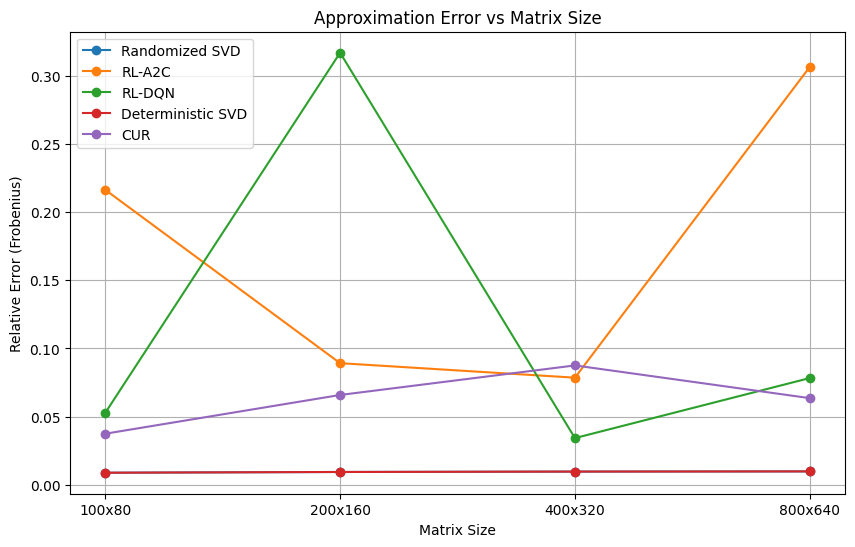

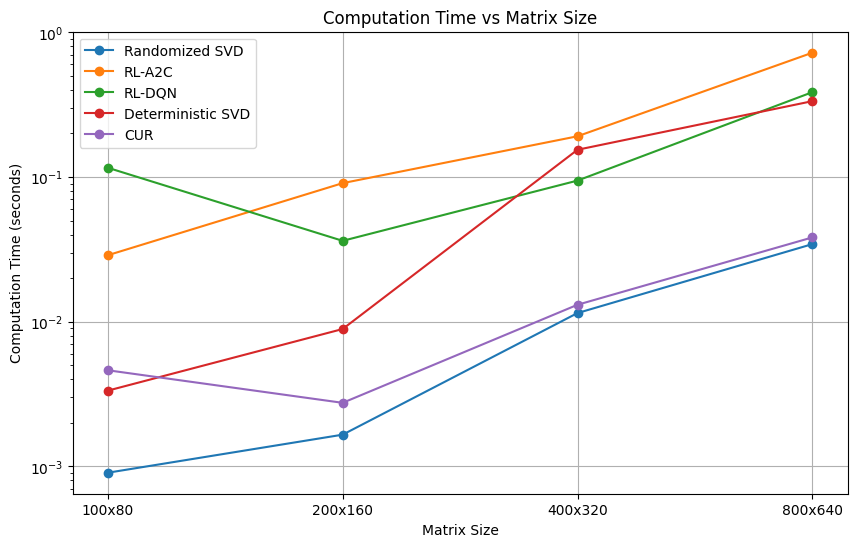

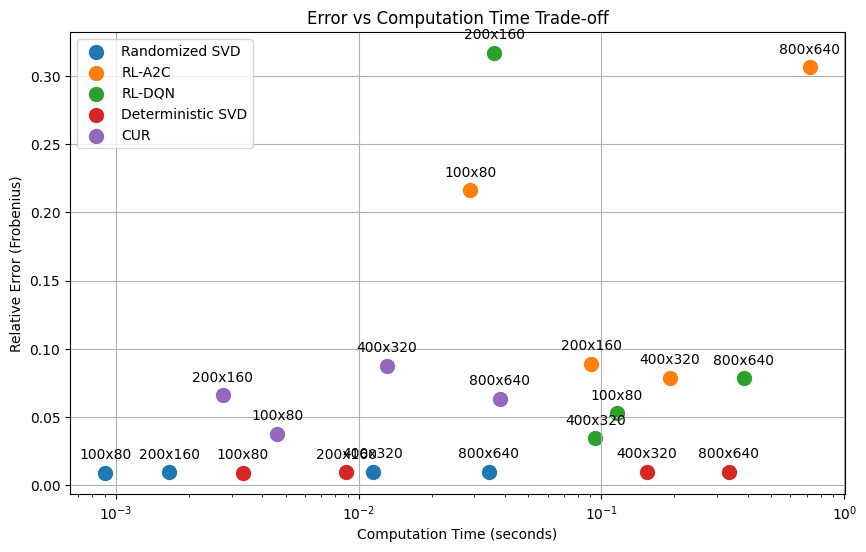

In [ ]:
def matrix_size_experiments():
    """Run experiments with different matrix sizes using saved models"""
    # Define matrix sizes to test
    sizes = [(100, 80), (200, 160), (400, 320), (800, 640)]
    true_rank = 10
    target_rank = 10

    results = {}
    for m, n in sizes:
        print(f"\nTesting matrix size {m}x{n}")
        A = generate_test_matrix(m, n, true_rank, 'low_rank_noise')

        results[(m, n)] = {}

        # Test deterministic SVD
        start = time.time()
        Ar_det = deterministic_rank_approx(A, target_rank)
        time_det = time.time() - start
        err_det = np.linalg.norm(A - Ar_det, 'fro') / np.linalg.norm(A, 'fro')
        results[(m, n)]['Deterministic SVD'] = {'error': err_det, 'time': time_det}
        print(f"Deterministic SVD - Error: {err_det:.4f}, Time: {time_det:.4f}s")

        # Test randomized SVD
        start = time.time()
        Ar_rand = randomized_rank_approx(A, target_rank)
        time_rand = time.time() - start
        err_rand = np.linalg.norm(A - Ar_rand, 'fro') / np.linalg.norm(A, 'fro')
        results[(m, n)]['Randomized SVD'] = {'error': err_rand, 'time': time_rand}
        print(f"Randomized SVD - Error: {err_rand:.4f}, Time: {time_rand:.4f}s")

        # Test CUR decomposition
        start = time.time()
        Ar_cur, _, _ = cur_decomposition(A, target_rank)
        time_cur = time.time() - start
        err_cur = np.linalg.norm(A - Ar_cur, 'fro') / np.linalg.norm(A, 'fro')
        results[(m, n)]['CUR'] = {'error': err_cur, 'time': time_cur}
        print(f"CUR Decomposition - Error: {err_cur:.4f}, Time: {time_cur:.4f}s")

        # Test RL methods only if models are available (for smaller matrices)
        if m <= 400 or True:
            try:
                # Load and test DQN agent
                model_path = f'models/dqn_model_{m}x{n}.pt'
                if os.path.exists(model_path):
                    # Create agent and load weights
                    env = ColumnSelectionEnv(A, target_rank)
                    state_dim = env.n
                    action_dim = env.n
                    dqn_agent = DQNAgent(state_dim, action_dim)
                    # Fixed: Load model to q_network instead of model
                    dqn_agent.q_network.load_state_dict(torch.load(model_path))

                    # Test DQN-based column selection
                    start = time.time()
                    Ar_dqn, _ = rl_column_selection_with_dqn(A, target_rank, dqn_agent)
                    time_dqn = time.time() - start
                    err_dqn = np.linalg.norm(A - Ar_dqn, 'fro') / np.linalg.norm(A, 'fro')
                    results[(m, n)]['RL-DQN'] = {'error': err_dqn, 'time': time_dqn}
                    print(f"RL-DQN - Error: {err_dqn:.4f}, Time: {time_dqn:.4f}s")
                else:
                    print(f"DQN model not found at {model_path}")
            except Exception as e:
                print(f"Error loading or testing DQN model for size {m}x{n}: {e}")

            try:
                # Load and test A2C agent
                # Fixed: Use the correct model path as saved in the training function
                a2c_model_path = f'models/a2c_model_{m}x{n}.pt'
                if os.path.exists(a2c_model_path):
                    # Create agent and load weights
                    env = EnhancedColumnSelectionEnv(A, target_rank, state_type='combined', reward_type='combined')
                    if env.state_type == 'combined':
                        state_dim = env.n * 3
                    else:
                        state_dim = env.n
                    action_dim = env.n
                    a2c_agent = A2CAgent(state_dim, action_dim)
                    # Fixed: Load the model correctly into a2c_agent.model
                    a2c_agent.model.load_state_dict(torch.load(a2c_model_path))

                    # Test A2C-based column selection
                    start = time.time()
                    Ar_a2c, _, info = rl_column_selection_with_a2c(A, target_rank, a2c_agent,
                                                                  state_type='combined', reward_type='combined')
                    time_a2c = time.time() - start
                    err_a2c = np.linalg.norm(A - Ar_a2c, 'fro') / np.linalg.norm(A, 'fro')
                    results[(m, n)]['RL-A2C'] = {'error': err_a2c, 'time': time_a2c}
                    print(f"RL-A2C - Error: {err_a2c:.4f}, Time: {time_a2c:.4f}s")
                else:
                    print(f"A2C model not found at {a2c_model_path}")
            except Exception as e:
                print(f"Error loading or testing A2C model for size {m}x{n}: {e}")

    # Save the results
    os.makedirs('results', exist_ok=True)  # Ensure directory exists
    with open('results/matrix_size_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    # Create and save comparison plots
    plot_size_comparison(results)
    return results

def plot_size_comparison(results):
    """Create plots comparing methods across different matrix sizes"""
    sizes = list(results.keys())

    # Find methods that are available for at least one matrix size
    all_methods = set()
    for size in sizes:
        all_methods.update(results[size].keys())

    # Prepare data for plotting
    size_labels = [f"{m}x{n}" for m, n in sizes]

    # Error comparison
    plt.figure(figsize=(10, 6))
    for method in all_methods:
        # Only include sizes where this method is available
        valid_sizes = [size for size in sizes if method in results[size]]
        if not valid_sizes:
            continue

        valid_labels = [f"{m}x{n}" for m, n in valid_sizes]
        errors = [results[size][method]['error'] for size in valid_sizes]
        plt.plot(valid_labels, errors, marker='o', label=method)

    plt.xlabel('Matrix Size')
    plt.ylabel('Relative Error (Frobenius)')
    plt.title('Approximation Error vs Matrix Size')
    plt.legend()
    plt.grid(True)
    plt.savefig('plots/error_vs_size.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Time comparison
    plt.figure(figsize=(10, 6))
    for method in all_methods:
        # Only include sizes where this method is available
        valid_sizes = [size for size in sizes if method in results[size]]
        if not valid_sizes:
            continue

        valid_labels = [f"{m}x{n}" for m, n in valid_sizes]
        times = [results[size][method]['time'] for size in valid_sizes]
        plt.plot(valid_labels, times, marker='o', label=method)

    plt.xlabel('Matrix Size')
    plt.ylabel('Computation Time (seconds)')
    plt.title('Computation Time vs Matrix Size')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Log scale for better visibility
    plt.savefig('plots/time_vs_size.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Error vs Time scatter plot
    plt.figure(figsize=(10, 6))
    for method in all_methods:
        # Only include sizes where this method is available
        valid_sizes = [size for size in sizes if method in results[size]]
        if not valid_sizes:
            continue

        errors = [results[size][method]['error'] for size in valid_sizes]
        times = [results[size][method]['time'] for size in valid_sizes]
        valid_labels = [f"{m}x{n}" for m, n in valid_sizes]

        plt.scatter(times, errors, label=method, s=100)

        # Connect points for the same method
        for i, size_label in enumerate(valid_labels):
            plt.annotate(
                size_label,
                (times[i], errors[i]),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center'
            )

    plt.xlabel('Computation Time (seconds)')
    plt.ylabel('Relative Error (Frobenius)')
    plt.title('Error vs Computation Time Trade-off')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Log scale for better visibility
    plt.savefig('plots/error_vs_time.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the experiments
import os
os.makedirs('plots', exist_ok=True)
matrix_size_results = matrix_size_experiments()

In [ ]:
def train_matrix_type_models():
    """Train and save RL models for different matrix types"""
    # Define matrix types to test
    matrix_types = ['low_rank_noise', 'exp_decay', 'clustered', 'ill_conditioned']
    m, n = 200, 160
    true_rank = 10
    target_rank = 10

    matrices = {}
    for matrix_type in matrix_types:
        print(f"\nGenerating and training for {matrix_type} matrix...")
        if matrix_type == 'ill_conditioned':
            A = generate_test_matrix(m, n, true_rank, matrix_type, condition_number=1e4)
        else:
            A = generate_test_matrix(m, n, true_rank, matrix_type)
        matrices[matrix_type] = A

        # Train DQN agent
        env = ColumnSelectionEnv(A, target_rank)
        state_dim = env.n
        action_dim = env.n
        dqn_agent = DQNAgent(state_dim, action_dim)
        print(f"Training DQN agent for {matrix_type} matrix...")
        train_dqn(dqn_agent, env, num_episodes=300)

        # Save DQN agent - fix: use q_network instead of model
        model_path = f'models/dqn_type_{matrix_type}.pt'
        torch.save(dqn_agent.q_network.state_dict(), model_path)
        print(f"DQN model saved to {model_path}")

        # Train A2C agent
        env = EnhancedColumnSelectionEnv(A, target_rank, state_type='combined', reward_type='combined')
        if env.state_type == 'combined':
            state_dim = env.n * 3  # Combined state has 3 channels
        else:
            state_dim = env.n
        action_dim = env.n
        a2c_agent = A2CAgent(state_dim, action_dim)
        print(f"Training A2C agent for {matrix_type} matrix...")
        train_a2c(a2c_agent, env, num_episodes=300)

        # Save A2C agent - fix: use model instead of actor/critic separately
        a2c_model_path = f'models/a2c_model_type_{matrix_type}.pt'
        torch.save(a2c_agent.model.state_dict(), a2c_model_path)
        print(f"A2C model saved to {a2c_model_path}")

    # Save matrices for later use
    with open('results/matrices.pkl', 'wb') as f:
        pickle.dump(matrices, f)

# Run the training
train_matrix_type_models()


Generating and training for low_rank_noise matrix...
Training DQN agent for low_rank_noise matrix...
Episode 50/300, Total Reward: 503.6324, Epsilon: 0.7783
Episode 100/300, Total Reward: 552.8008, Epsilon: 0.6058
Episode 150/300, Total Reward: 520.6935, Epsilon: 0.4715
Episode 200/300, Total Reward: 561.5504, Epsilon: 0.3670
Episode 250/300, Total Reward: 551.4409, Epsilon: 0.2856
Episode 300/300, Total Reward: 547.4605, Epsilon: 0.2223
DQN model saved to models/dqn_type_low_rank_noise.pt
Training A2C agent for low_rank_noise matrix...
Episode 50/300, Reward: 1.0796, Error: 0.1204, Steps: 10
Episode 100/300, Reward: 1.1193, Error: 0.0807, Steps: 10
Episode 150/300, Reward: 1.3495, Error: 0.0505, Steps: 10
Episode 200/300, Reward: 1.0196, Error: 0.1804, Steps: 10
Episode 250/300, Reward: 1.1660, Error: 0.0340, Steps: 10
Episode 300/300, Reward: 1.2046, Error: 0.0954, Steps: 10
A2C model saved to models/a2c_model_type_low_rank_noise.pt

Generating and training for exp_decay matrix...
T

Loaded matrices from file.
Loaded DQN agent for low_rank_noise matrix
Loaded A2C agent for low_rank_noise matrix
Loaded DQN agent for exp_decay matrix
Loaded A2C agent for exp_decay matrix
Loaded DQN agent for clustered matrix
Loaded A2C agent for clustered matrix
Loaded DQN agent for ill_conditioned matrix
Loaded A2C agent for ill_conditioned matrix
Testing Deterministic SVD on low_rank_noise with rank 10
Testing Randomized SVD on low_rank_noise with rank 10
Testing CUR on low_rank_noise with rank 10
Testing RL-DQN (low_rank_noise) on low_rank_noise with rank 10
Testing RL-A2C (low_rank_noise) on low_rank_noise with rank 10
Testing RL-DQN (exp_decay) on low_rank_noise with rank 10
Testing RL-A2C (exp_decay) on low_rank_noise with rank 10
Testing RL-DQN (clustered) on low_rank_noise with rank 10
Testing RL-A2C (clustered) on low_rank_noise with rank 10
Testing RL-DQN (ill_conditioned) on low_rank_noise with rank 10
Testing RL-A2C (ill_conditioned) on low_rank_noise with rank 10
Testing

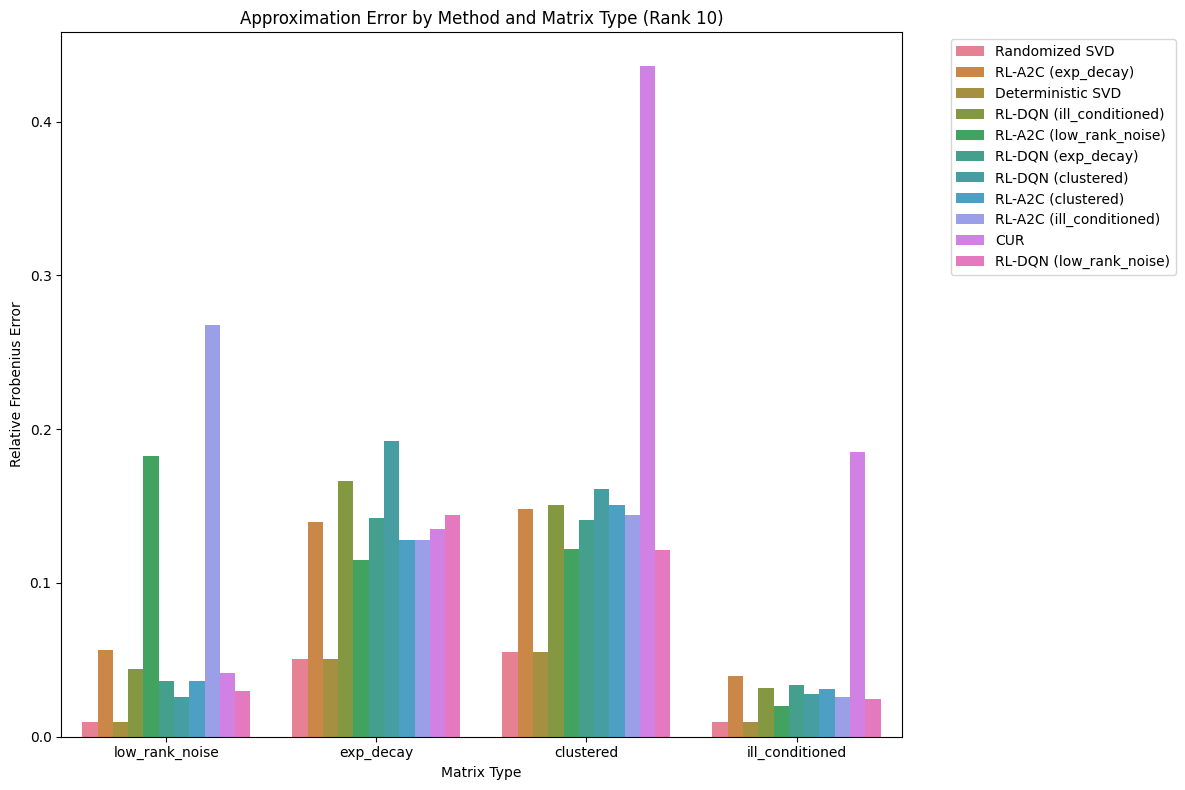

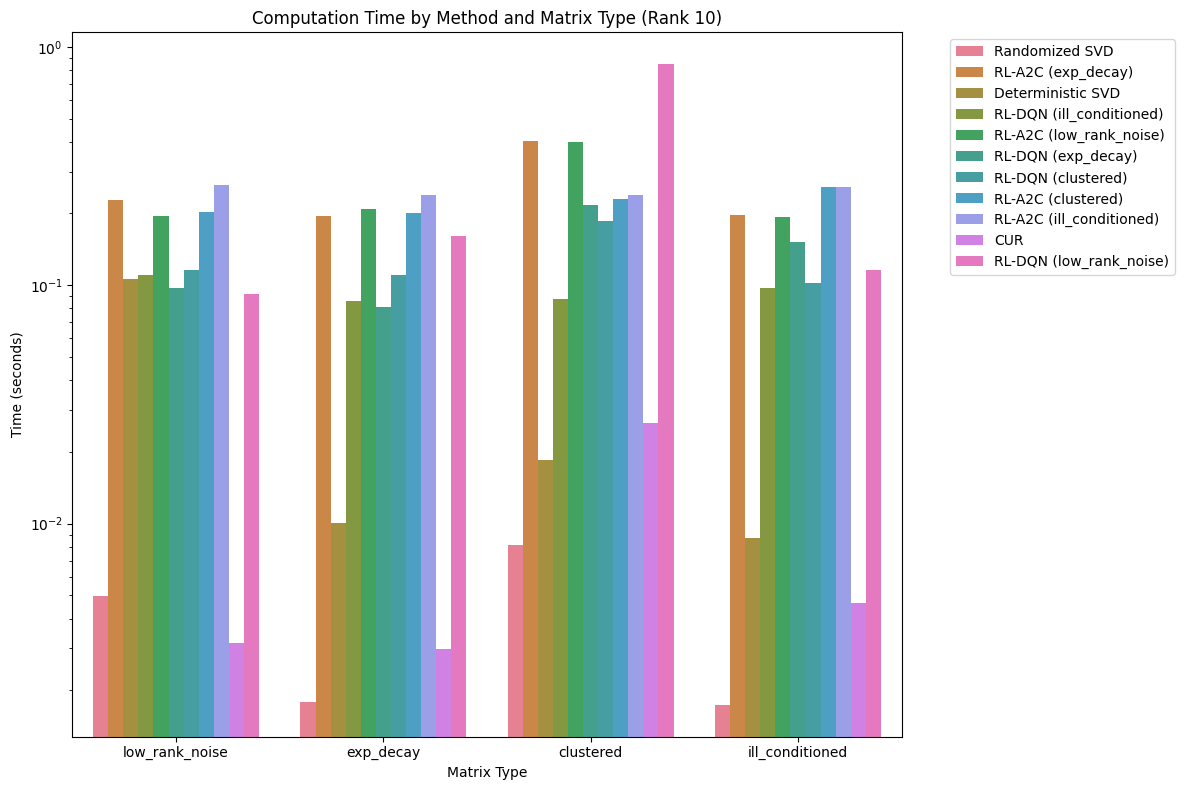

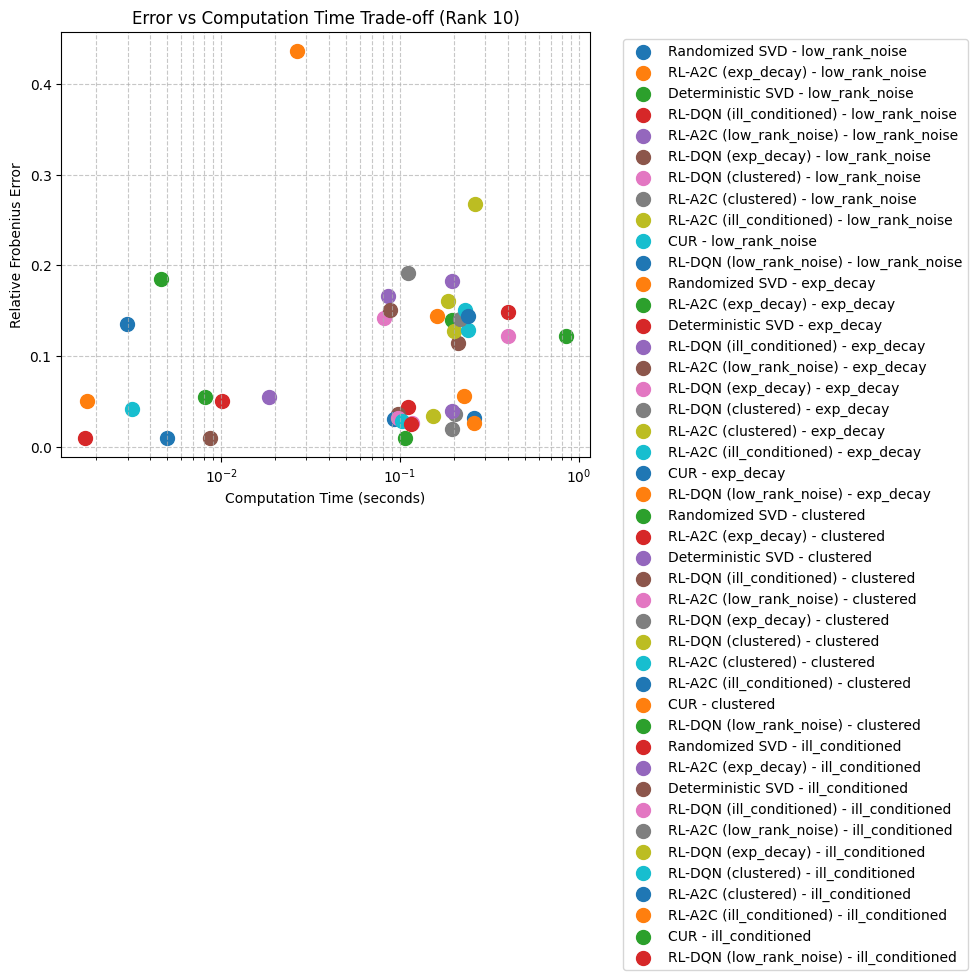

In [ ]:
def matrix_type_experiments():
    """Run experiments with different matrix types using saved models"""
    # Define matrix types to test
    matrix_types = ['low_rank_noise', 'exp_decay', 'clustered', 'ill_conditioned']
    m, n = 200, 160
    true_rank = 10
    target_rank = 10

    # Load matrices if available, otherwise generate them
    try:
        with open('results/matrices.pkl', 'rb') as f:
            matrices = pickle.load(f)
        print("Loaded matrices from file.")
    except:
        print("Generating new matrices...")
        matrices = {}
        for matrix_type in matrix_types:
            print(f"\nGenerating {matrix_type} matrix...")
            if matrix_type == 'ill_conditioned':
                A = generate_test_matrix(m, n, true_rank, matrix_type, condition_number=1e4)
            else:
                A = generate_test_matrix(m, n, true_rank, matrix_type)
            matrices[matrix_type] = A

        # Save the generated matrices
        os.makedirs('results', exist_ok=True)
        with open('results/matrices.pkl', 'wb') as f:
            pickle.dump(matrices, f)

    # Define methods to compare
    methods = {
        'Deterministic SVD': lambda A, r: deterministic_rank_approx(A, r),
        'Randomized SVD': lambda A, r: randomized_rank_approx(A, r),
        'CUR': lambda A, r: cur_decomposition(A, r)[0],
    }

    # Load RL agents
    dqn_agents = {}
    a2c_agents = {}

    for matrix_type in matrix_types:
        try:
            # Load DQN agent - Fixed: use correct path and attribute name
            dqn_model_path = f'models/dqn_type_{matrix_type}.pt'
            if os.path.exists(dqn_model_path):
                A = matrices[matrix_type]
                env = ColumnSelectionEnv(A, target_rank)
                state_dim = env.n
                action_dim = env.n
                dqn_agent = DQNAgent(state_dim, action_dim)
                # Fixed: load to q_network instead of model
                dqn_agent.q_network.load_state_dict(torch.load(dqn_model_path))
                dqn_agents[matrix_type] = dqn_agent
                print(f"Loaded DQN agent for {matrix_type} matrix")
            else:
                print(f"DQN model not found at {dqn_model_path}")
        except Exception as e:
            print(f"Error loading DQN model for {matrix_type}: {e}")

        try:
            # Load A2C agent - Fixed: use correct path format and single model file
            a2c_model_path = f'models/a2c_model_type_{matrix_type}.pt'
            if os.path.exists(a2c_model_path):
                A = matrices[matrix_type]
                env = EnhancedColumnSelectionEnv(A, target_rank, state_type='combined', reward_type='combined')
                if env.state_type == 'combined':
                    state_dim = env.n * 3
                else:
                    state_dim = env.n
                action_dim = env.n
                a2c_agent = A2CAgent(state_dim, action_dim)
                # Fixed: load to model instead of actor/critic separately
                a2c_agent.model.load_state_dict(torch.load(a2c_model_path))
                a2c_agents[matrix_type] = a2c_agent
                print(f"Loaded A2C agent for {matrix_type} matrix")
            else:
                print(f"A2C model not found at {a2c_model_path}")
        except Exception as e:
            print(f"Error loading A2C model for {matrix_type}: {e}")

    # Add RL methods to comparison for matrix types where models are available
    for matrix_type in matrix_types:
        if matrix_type in dqn_agents:
            methods[f'RL-DQN ({matrix_type})'] = lambda A, r, mt=matrix_type: rl_column_selection_with_dqn(A, r, dqn_agents[mt])[0]
        if matrix_type in a2c_agents:
            methods[f'RL-A2C ({matrix_type})'] = lambda A, r, mt=matrix_type: rl_column_selection_with_a2c(A, r, a2c_agents[mt], state_type='combined', reward_type='combined')[0]

    # Run comparison
    results = comprehensive_method_comparison(
        matrices,
        [target_rank],
        methods,
        metrics=['frobenius', 'spectral', 'nuclear', 'rank']
    )

    # Save results
    os.makedirs('results', exist_ok=True)
    with open('results/matrix_type_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    # Format and print results
    for matrix_type in matrix_types:
        print(f"\nResults for {matrix_type} matrix:")
        method_names = list(results[matrix_type][target_rank].keys())
        table = format_results_table(results, 'frobenius', [matrix_type], method_names, [target_rank])
        print(table)

    # Create and save comparison plots
    plot_matrix_type_comparison(results, target_rank)
    return results

def plot_matrix_type_comparison(results, target_rank):
    """Create plots comparing methods across different matrix types"""
    matrix_types = list(results.keys())
    os.makedirs('plots', exist_ok=True)  # Ensure plots directory exists

    # Get common methods across all matrix types
    common_methods = set(results[matrix_types[0]][target_rank].keys())
    for matrix_type in matrix_types:
        common_methods = common_methods.intersection(results[matrix_type][target_rank].keys())
    common_methods = list(common_methods)

    # Prepare data for bar charts
    error_data = []
    time_data = []

    for matrix_type in matrix_types:
        for method in common_methods:
            error_data.append({
                'Matrix Type': matrix_type,
                'Method': method,
                'Error': results[matrix_type][target_rank][method]['frobenius']
            })
            time_data.append({
                'Matrix Type': matrix_type,
                'Method': method,
                'Time (s)': results[matrix_type][target_rank][method]['time']
            })

    error_df = pd.DataFrame(error_data)
    time_df = pd.DataFrame(time_data)

    # Plot error comparison
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Matrix Type', y='Error', hue='Method', data=error_df)
    plt.title(f'Approximation Error by Method and Matrix Type (Rank {target_rank})')
    plt.ylabel('Relative Frobenius Error')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('plots/error_by_matrix_type.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot time comparison
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Matrix Type', y='Time (s)', hue='Method', data=time_df)
    plt.title(f'Computation Time by Method and Matrix Type (Rank {target_rank})')
    plt.ylabel('Time (seconds)')
    plt.yscale('log')  # Log scale for better visibility
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('plots/time_by_matrix_type.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create a scatter plot of error vs time
    plt.figure(figsize=(10, 8))

    for matrix_type in matrix_types:
        for method in common_methods:
            error = results[matrix_type][target_rank][method]['frobenius']
            time_val = results[matrix_type][target_rank][method]['time']
            plt.scatter(time_val, error, label=f"{method} - {matrix_type}", marker='o', s=100)

    plt.xlabel('Computation Time (seconds)')
    plt.ylabel('Relative Frobenius Error')
    plt.title(f'Error vs Computation Time Trade-off (Rank {target_rank})')
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('plots/error_vs_time_by_matrix_type.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the experiments
os.makedirs('results', exist_ok=True)
matrix_type_results = matrix_type_experiments()

In [ ]:
# import requests
# import scipy.io
# import tarfile
# # import io
# import scipy.sparse as sparse
# from sklearn.model_selection import train_test_split
# import urllib.request
# from pathlib import Path

# def download_matrix_from_ssmc(matrix_id, matrix_name, group, save_dir="florida_matrices"):
#     """
#     Download a matrix from the SuiteSparse Matrix Collection (formerly Florida Collection)

#     Parameters:
#     -----------
#     matrix_id : str
#         ID of the matrix in the collection
#     matrix_name : str
#         Name of the matrix
#     group : str
#         Group (collection) the matrix belongs to
#     save_dir : str
#         Directory to save the downloaded matrix

#     Returns:
#     --------
#     matrix_path : str
#         Path to the saved matrix file
#     """
#     os.makedirs(save_dir, exist_ok=True)
#     matrix_path = os.path.join(save_dir, f"{matrix_name}.npz")

#     # Check if matrix is already downloaded
#     if os.path.exists(matrix_path):
#         print(f"Matrix {matrix_name} already exists at {matrix_path}")
#         return matrix_path

#     print(f"Downloading matrix {matrix_name} from group {group}...")

#     # URL for the matrix
#     base_url = "https://sparse.tamu.edu/mat"
#     matrix_url = f"{base_url}/{group}/{matrix_name}.mat"

#     try:
#         # Download the .mat file
#         response = requests.get(matrix_url, stream=True)
#         response.raise_for_status()  # Raise an error for bad responses

#         # Load the matrix from the .mat file
#         mat_content = scipy.io.loadmat(io.BytesIO(response.content))

#         # The matrix is stored with the key 'Problem'
#         matrix_data = mat_content["Problem"]

#         # The actual matrix is in the 'A' field
#         A = matrix_data["A"][0, 0]

#         # Convert to dense if the matrix is sparse
#         if sparse.issparse(A):
#             A = A.toarray()

#         # Save as .npz for efficient storage
#         np.savez_compressed(matrix_path, matrix=A)
#         print(f"Matrix saved to {matrix_path}")

#         return matrix_path

#     except Exception as e:
#         print(f"Error downloading matrix {matrix_name}: {str(e)}")
#         return None

# def load_florida_matrix(matrix_path):
#     """
#     Load a Florida matrix from a saved .npz file

#     Parameters:
#     -----------
#     matrix_path : str
#         Path to the .npz file containing the matrix

#     Returns:
#     --------
#     A : numpy array
#         Loaded matrix
#     """
#     data = np.load(matrix_path)
#     A = data["matrix"]
#     return A

# def preprocess_florida_matrix(A, max_size=1000):
#     """
#     Preprocess a Florida matrix to make it suitable for experiments

#     Parameters:
#     -----------
#     A : numpy array
#         Input matrix
#     max_size : int
#         Maximum dimension allowed

#     Returns:
#     --------
#     A_processed : numpy array
#         Processed matrix ready for experiments
#     """
#     # Convert to dense if it's sparse
#     if sparse.issparse(A): ### This checks whether the matrix is sparse or not
#         A = A.toarray()

#     # Handle complex matrices by taking absolute values
#     if np.iscomplexobj(A):  ### converting complex matrix to their abs vals
#         A = np.abs(A)

#     # Handle NaNs and infinities
#     A = np.nan_to_num(A)

#     # Handle large matrices by slicing
#     m, n = A.shape
#     if m > max_size or n > max_size:
#         m_new = min(m, max_size)
#         n_new = min(n, max_size)
#         A = A[:m_new, :n_new]

#     # Normalize to avoid numerical instability
#     if np.max(np.abs(A)) > 0:
#         A = A / np.max(np.abs(A))

#     return A

In [ ]:
# def florida_matrix_experiments():
#     """Run experiments with matrices from the SuiteSparse Matrix Collection

#     This will be run from

#     """
#     # Define matrices to download
#     # Selected matrices that are suitable for low-rank approximation
#     matrix_info_list = [
#             {"id": 187, "name": "jpwh_991", "group": "HB"},
#     {"id": 2061, "name": "mk11-b1", "group": "JGD_Homology"},
#     {"id": 270, "name": "west0989", "group": "HB"},
#     {"id": 424, "name": "ex27", "group": "FIDAP"},
#     {"id": 2188, "name": "D_6", "group": "JGD_SL6"},
#     {"id": 333, "name": "rdb968", "group": "Bai"},
#     {"id": 300, "name": "cdde1", "group": "Bai"},
#     {"id": 304, "name": "cdde5", "group": "Bai"},
#     {"id": 1618, "name": "dwg961a", "group": "Bai"},
#     {"id": 305, "name": "cdde6", "group": "Bai"},
#     {"id": 1619, "name": "dwg961b", "group": "Bai"},
#     {"id": 302, "name": "cdde3", "group": "Bai"},
#     {"id": 301, "name": "cdde2", "group": "Bai"},
#     {"id": 303, "name": "cdde4", "group": "Bai"},
#     {"id": 219, "name": "nos3", "group": "HB"},
#     {"id": 12, "name": "ash958", "group": "HB"},
#     {"id": 218, "name": "nos2", "group": "HB"},
#     {"id": 2429, "name": "L", "group": "AG-Monien"},
#     {"id": 1478, "name": "GD01_Acap", "group": "Pajek"},

#     {"id": 2737, "name": "spaceStation_4", "group": "VDOL"},
#     {"id": 176, "name": "jagmesh1", "group": "HB"},
#     {"id": 138, "name": "dwt_918", "group": "HB"},
#     {"id": 2721, "name": "orbitRaising_4", "group": "VDOL"},
#     {"id": 2334, "name": "DK01R", "group": "Fluorem"},
#     {"id": 159, "name": "gr_30_30", "group": "HB"},
#     {"id": 325, "name": "pde900", "group": "Bai"},
#     {"id": 226, "name": "orsirr_2", "group": "HB"},
#     {"id": 328, "name": "qh882", "group": "Bai"},
#     {"id": 2027, "name": "ch7-7-b1", "group": "JGD_Homology"},
#     {"id": 137, "name": "dwt_878", "group": "HB"},
#     {"id": 135, "name": "dwt_869", "group": "HB"},
#     {"id": 2690, "name": "goddardRocketProblem_2", "group": "VDOL"},
#     {"id": 422, "name": "ex25", "group": "FIDAP"},
#     {"id": 2888, "name": "Vehicle_10NN", "group": "ML_Graph"},
#     {"id": 279, "name": "young2c", "group": "HB"},
#     {"id": 278, "name": "young1c", "group": "HB"},
#     {"id": 280, "name": "young3c", "group": "HB"},
#     {"id": 281, "name": "young4c", "group": "HB"},
#     {"id": 419, "name": "ex22", "group": "FIDAP"},

#     {"id": 107, "name": "can_838", "group": "HB"},
#     {"id": 2689, "name": "goddardRocketProblem", "group": "VDOL"},
#     {"id": 87, "name": "bp_200", "group": "HB"},
#     {"id": 88, "name": "bp_400", "group": "HB"},
#     {"id": 84, "name": "bp_1200", "group": "HB"},
#     {"id": 85, "name": "bp_1400", "group": "HB"},
#     {"id": 86, "name": "bp_1600", "group": "HB"},
#     {"id": 83, "name": "bp_1000", "group": "HB"},
#     {"id": 89, "name": "bp_600", "group": "HB"},
#     {"id": 82, "name": "bp_0", "group": "HB"},
#     {"id": 90, "name": "bp_800", "group": "HB"},
#     {"id": 69, "name": "bcsstm19", "group": "HB"},
#     {"id": 41, "name": "bcsstk19", "group": "HB"},
#     {"id": 479, "name": "G19", "group": "Gset"},
#     {"id": 480, "name": "G2", "group": "Gset"},
#     {"id": 469, "name": "G1", "group": "Gset"},
#     {"id": 478, "name": "G18", "group": "Gset"},
#     {"id": 524, "name": "G6", "group": "Gset"},
#     {"id": 534, "name": "G8", "group": "Gset"},
#     {"id": 472, "name": "G12", "group": "Gset"}
#     ]

#     # Download matrices
#     matrices = {}
#     for matrix_info in matrix_info_list:
#         matrix_id = matrix_info["id"]
#         matrix_name = matrix_info["name"]
#         group = matrix_info["group"]

#         print(f"Processing matrix {matrix_name}...")
#         matrix_path = download_matrix_from_ssmc(matrix_id, matrix_name, group)

#         if (matrix_path):
#             try:
#                 # Load and preprocess the matrix
#                 A = load_florida_matrix(matrix_path)
#                 A = preprocess_florida_matrix(A)
#                 matrices[matrix_name] = A
#                 print(f"Loaded matrix {matrix_name} with shape {A.shape}")
#             except Exception as e:
#                 print(f"Error loading matrix {matrix_name}: {str(e)}")

#     # Run experiments on each matrix
#     results = {}
#     target_rank = 10

#     for matrix_name, A in matrices.items():
#         print(f"\nTesting {matrix_name}")
#         results[matrix_name] = {}

#         # Test deterministic SVD
#         start = time.time()
#         Ar_det = deterministic_rank_approx(A, target_rank)
#         time_det = time.time() - start
#         err_det = np.linalg.norm(A - Ar_det, "fro") / np.linalg.norm(A, "fro")
#         results[matrix_name]["Deterministic SVD"] = {"error": err_det, "time": time_det}
#         print(f"Deterministic SVD - Error: {err_det:.4f}, Time: {time_det:.4f}s")

#         # Test randomized SVD
#         start = time.time()
#         Ar_rand = randomized_rank_approx(A, target_rank)
#         time_rand = time.time() - start
#         err_rand = np.linalg.norm(A - Ar_rand, "fro") / np.linalg.norm(A, "fro")
#         results[matrix_name]["Randomized SVD"] = {"error": err_rand, "time": time_rand}
#         print(f"Randomized SVD - Error: {err_rand:.4f}, Time: {time_rand:.4f}s")

#         # Define ColumnSelectionEnv for this matrix
#         try:
#             # Test DQN-based column selection (if the matrix is not too large)
#             if A.shape[1] < 1000:  # Only try RL for matrices with reasonable number of columns
#                 # Create and train DQN agent
#                 env = ColumnSelectionEnv(A, target_rank)
#                 state_dim = env.n
#                 action_dim = env.n
#                 dqn_agent = DQNAgent(state_dim, action_dim)
#                 print(f"Training DQN agent for {matrix_name}...")
#                 train_dqn(dqn_agent, env, num_episodes=200)  # Fewer episodes for large matrices

#                 # Test trained DQN agent
#                 start = time.time()
#                 Ar_dqn, selected_cols = rl_column_selection_with_dqn(A, target_rank, dqn_agent)
#                 time_dqn = time.time() - start
#                 err_dqn = np.linalg.norm(A - Ar_dqn, "fro") / np.linalg.norm(A, "fro")
#                 results[matrix_name]["RL-DQN"] = {
#                     "error": err_dqn,
#                     "time": time_dqn,
#                     "selected_columns": selected_cols
#                 }
#                 print(f"RL-DQN - Error: {err_dqn:.4f}, Time: {time_dqn:.4f}s")
#                 print(f"Selected columns: {selected_cols}")
#         except Exception as e:
#             print(f"Error running RL experiments for {matrix_name}: {str(e)}")

#     # Compare results across matrices
#     print("\n\nResults Summary:")
#     for matrix_name in results:
#         print(f"\n{matrix_name}:")
#         for method in results[matrix_name]:
#             if isinstance(results[matrix_name][method], dict) and "error" in results[matrix_name][method]:
#                 print(f"  {method}: Error = {results[matrix_name][method]['error']:.4f}, Time = {results[matrix_name][method]['time']:.4f}s")

#     # Plot comparison
#     plot_florida_results(results)

#     return results

# def plot_florida_results(results):
#     """Plot comparison of methods on Florida matrices"""
#     # Prepare data for plotting
#     matrix_names = list(results.keys())
#     methods = ["Deterministic SVD", "Randomized SVD", "RL-DQN"]

#     # Error comparison
#     plt.figure(figsize=(10, 6))
#     bar_width = 0.25
#     index = np.arange(len(matrix_names))

#     for i, method in enumerate(methods):
#         errors = []
#         for matrix in matrix_names:
#             if method in results[matrix]:
#                 errors.append(results[matrix][method]["error"])
#             else:
#                 errors.append(np.nan)  # Use NaN for missing data

#         plt.bar(index + i*bar_width, errors, bar_width, label=method)

#     plt.xlabel('Matrix')
#     plt.ylabel('Relative Error (Frobenius)')
#     plt.title('Approximation Error Comparison on Florida Matrices')
#     plt.xticks(index + bar_width, matrix_names, rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig('florida_error_comparison.png', dpi=300)
#     plt.show()

#     # Time comparison
#     plt.figure(figsize=(10, 6))

#     for i, method in enumerate(methods):
#         times = []
#         for matrix in matrix_names:
#             if method in results[matrix]:
#                 times.append(results[matrix][method]["time"])
#             else:
#                 times.append(np.nan)  # Use NaN for missing data

#         plt.bar(index + i*bar_width, times, bar_width, label=method)

#     plt.xlabel('Matrix')
#     plt.ylabel('Computation Time (seconds)')
#     plt.title('Computation Time Comparison on Florida Matrices')
#     plt.xticks(index + bar_width, matrix_names, rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig('florida_time_comparison.png', dpi=300)
#     plt.show()


In [ ]:
# Set random seeds for reproducibility
set_random_seeds(42)

# Run experiments with Florida matrices
# florida_results = florida_matrix_experiments()

# Save results
# with open('results/florida_matrix_results.pkl', 'wb') as f:
#     pickle.dump(florida_results, f)

# print("Florida matrix experiments completed and results saved to 'results/florida_matrix_results.pkl'")

In [ ]:
# def florida_matrix_train_test_experiments():
#     """Run experiments with matrices from the SuiteSparse Matrix Collection using train/test splitting"""
#     # Define matrices to download
#     # Selected matrices that are suitable for low-rank approximation
#     matrix_info_list = [
#  {"id": 187, "name": "jpwh_991", "group": "HB"},
#     {"id": 2061, "name": "mk11-b1", "group": "JGD_Homology"},
#     {"id": 270, "name": "west0989", "group": "HB"},
#     {"id": 424, "name": "ex27", "group": "FIDAP"},
#     {"id": 2188, "name": "D_6", "group": "JGD_SL6"},
#     {"id": 333, "name": "rdb968", "group": "Bai"},
#     {"id": 300, "name": "cdde1", "group": "Bai"},
#     {"id": 304, "name": "cdde5", "group": "Bai"},
#     {"id": 1618, "name": "dwg961a", "group": "Bai"},
#     {"id": 305, "name": "cdde6", "group": "Bai"},
#     {"id": 1619, "name": "dwg961b", "group": "Bai"},
#     {"id": 302, "name": "cdde3", "group": "Bai"},
#     {"id": 301, "name": "cdde2", "group": "Bai"},
#     {"id": 303, "name": "cdde4", "group": "Bai"},
#     {"id": 219, "name": "nos3", "group": "HB"},
#     {"id": 12, "name": "ash958", "group": "HB"},
#     {"id": 218, "name": "nos2", "group": "HB"},
#     {"id": 2429, "name": "L", "group": "AG-Monien"},
#     {"id": 1478, "name": "GD01_Acap", "group": "Pajek"},

#     {"id": 2737, "name": "spaceStation_4", "group": "VDOL"},
#     {"id": 176, "name": "jagmesh1", "group": "HB"},
#     {"id": 138, "name": "dwt_918", "group": "HB"},
#     {"id": 2721, "name": "orbitRaising_4", "group": "VDOL"},
#     {"id": 2334, "name": "DK01R", "group": "Fluorem"},
#     {"id": 159, "name": "gr_30_30", "group": "HB"},
#     {"id": 325, "name": "pde900", "group": "Bai"},
#     {"id": 226, "name": "orsirr_2", "group": "HB"},
#     {"id": 328, "name": "qh882", "group": "Bai"},
#     {"id": 2027, "name": "ch7-7-b1", "group": "JGD_Homology"},
#     {"id": 137, "name": "dwt_878", "group": "HB"},
#     {"id": 135, "name": "dwt_869", "group": "HB"},
#     {"id": 2690, "name": "goddardRocketProblem_2", "group": "VDOL"},
#     {"id": 422, "name": "ex25", "group": "FIDAP"},
#     {"id": 2888, "name": "Vehicle_10NN", "group": "ML_Graph"},
#     {"id": 279, "name": "young2c", "group": "HB"},
#     {"id": 278, "name": "young1c", "group": "HB"},
#     {"id": 280, "name": "young3c", "group": "HB"},
#     {"id": 281, "name": "young4c", "group": "HB"},
#     {"id": 419, "name": "ex22", "group": "FIDAP"},

#     {"id": 107, "name": "can_838", "group": "HB"},
#     {"id": 2689, "name": "goddardRocketProblem", "group": "VDOL"},
#     {"id": 87, "name": "bp_200", "group": "HB"},
#     {"id": 88, "name": "bp_400", "group": "HB"},
#     {"id": 84, "name": "bp_1200", "group": "HB"},
#     {"id": 85, "name": "bp_1400", "group": "HB"},
#     {"id": 86, "name": "bp_1600", "group": "HB"},
#     {"id": 83, "name": "bp_1000", "group": "HB"},
#     {"id": 89, "name": "bp_600", "group": "HB"},
#     {"id": 82, "name": "bp_0", "group": "HB"},
#     {"id": 90, "name": "bp_800", "group": "HB"},
#     {"id": 69, "name": "bcsstm19", "group": "HB"},
#     {"id": 41, "name": "bcsstk19", "group": "HB"},
#     {"id": 479, "name": "G19", "group": "Gset"},
#     {"id": 480, "name": "G2", "group": "Gset"},
#     {"id": 469, "name": "G1", "group": "Gset"},
#     {"id": 478, "name": "G18", "group": "Gset"},
#     {"id": 524, "name": "G6", "group": "Gset"},
#     {"id": 534, "name": "G8", "group": "Gset"},
#     {"id": 472, "name": "G12", "group": "Gset"}
#     ]

#     # Download all matrices first
#     matrices = {}
#     for matrix_info in matrix_info_list:
#         matrix_id = matrix_info["id"]
#         matrix_name = matrix_info["name"]
#         group = matrix_info["group"]

#         print(f"Processing matrix {matrix_name}...")
#         matrix_path = download_matrix_from_ssmc(matrix_id, matrix_name, group)

#         if matrix_path:
#             try:
#                 # Load and preprocess the matrix
#                 A = load_florida_matrix(matrix_path)
#                 A = preprocess_florida_matrix(A)
#                 matrices[matrix_name] = A
#                 print(f"Loaded matrix {matrix_name} with shape {A.shape}")
#             except Exception as e:
#                 print(f"Error loading matrix {matrix_name}: {str(e)}")

#     # Split matrices into train and test sets
#     from sklearn.model_selection import train_test_split
#     matrix_names = list(matrices.keys())
#     train_names, test_names = train_test_split(matrix_names, test_size=0.5, random_state=42)

#     print(f"Train matrices: {train_names}")
#     print(f"Test matrices: {test_names}")

#     # Create dictionaries of train and test matrices
#     train_matrices = {name: matrices[name] for name in train_names}
#     test_matrices = {name: matrices[name] for name in test_names}

#     # Define target rank for experiments
#     target_rank = 10

#     # Train RL agents on each training matrix
#     print("\nTraining RL agents on Florida training matrices...")
#     dqn_agents = {}
#     a2c_agents = {}

#     for matrix_name, A in train_matrices.items():
#         print(f"\nTraining agents on {matrix_name} matrix...")

#         # Train DQN agent
#         env = ColumnSelectionEnv(A, target_rank)
#         state_dim = env.n
#         action_dim = env.n
#         dqn_agent = DQNAgent(state_dim, action_dim)
#         print(f"Training DQN agent for {matrix_name}...")
#         train_dqn(dqn_agent, env, num_episodes=200)  # Fewer episodes for real matrices
#         dqn_agents[matrix_name] = dqn_agent

#         # Save DQN agent
#         model_path = f'models/dqn_florida_{matrix_name}.pt'
#         torch.save(dqn_agent.q_network.state_dict(), model_path)
#         print(f"DQN model saved to {model_path}")

#         # Train A2C agent
#         env = EnhancedColumnSelectionEnv(A, target_rank, state_type='combined', reward_type='combined')
#         if env.state_type == 'combined':
#             state_dim = env.n * 3  # Combined state has 3 channels
#         else:
#             state_dim = env.n
#         action_dim = env.n
#         a2c_agent = A2CAgent(state_dim, action_dim)
#         print(f"Training A2C agent for {matrix_name}...")
#         train_a2c(a2c_agent, env, num_episodes=200)  # Fewer episodes for real matrices
#         a2c_agents[matrix_name] = a2c_agent

#         # Save A2C agent
#         model_path = f'models/a2c_model_florida_{matrix_name}.pt'
#         torch.save(a2c_agent.model.state_dict(), model_path)
#         print(f"A2C model saved to {model_path}")

#     # Define methods to compare
#     base_methods = {
#         "Deterministic SVD": lambda A, r: deterministic_rank_approx(A, r),
#         "Randomized SVD": lambda A, r: randomized_rank_approx(A, r),
#         "CUR": lambda A, r: cur_decomposition(A, r)[0],
#     }

#     # Evaluate on test matrices
#     results = {}
#     print("\nEvaluating methods on test matrices...")

#     for test_matrix_name, A in test_matrices.items():
#         results[test_matrix_name] = {}
#         print(f"\nEvaluating on {test_matrix_name}")

#         # Define RL methods specific to each training matrix
#         rl_methods = {}
#         for train_matrix_name in train_matrices.keys():
#             if train_matrix_name in dqn_agents:
#                 rl_methods[f"RL-DQN ({train_matrix_name})"] = (
#                     lambda A, r, name=train_matrix_name: rl_column_selection_with_dqn(
#                         A, r, dqn_agents[name])[0]
#                 )

#             if train_matrix_name in a2c_agents:
#                 rl_methods[f"RL-A2C ({train_matrix_name})"] = (
#                     lambda A, r, name=train_matrix_name: rl_column_selection_with_a2c(
#                         A, r, a2c_agents[name], state_type='combined', reward_type='combined'
#                     )[0]
#                 )

#         # Combine base methods and RL methods
#         methods = {**base_methods, **rl_methods}

#         # Test all methods on this test matrix
#         for method_name, method_fn in methods.items():
#             print(f"Testing {method_name} on {test_matrix_name}")

#             # Time the method
#             start_time = time.time()

#             try:
#                 # Apply method to get low rank approximation
#                 Ar = method_fn(A, target_rank)

#                 # Calculate error
#                 rel_error = np.linalg.norm(A - Ar, 'fro') / np.linalg.norm(A, 'fro')
#                 elapsed_time = time.time() - start_time

#                 # Store results
#                 results[test_matrix_name][method_name] = {
#                     'error': rel_error,
#                     'time': elapsed_time
#                 }

#                 print(f"{method_name} - Error: {rel_error:.4f}, Time: {elapsed_time:.4f}s")
#             except Exception as e:
#                 print(f"Error running {method_name} on {test_matrix_name}: {str(e)}")
#                 results[test_matrix_name][method_name] = {
#                     'error': float('nan'),
#                     'time': float('nan')
#                 }

#     # Save results
#     with open('results/florida_train_test_results.pkl', 'wb') as f:
#         pickle.dump(results, f)

#     # Plot results
#     plot_florida_train_test_results(results, train_names)

#     return results, train_matrices, test_matrices

# def plot_florida_train_test_results(results, train_names):
#     """Plot comparison of methods on Florida matrices with train/test splitting"""
#     # Prepare data for plotting
#     test_matrix_names = list(results.keys())

#     # Find common methods across all test matrices
#     common_methods = set()
#     for matrix_name in test_matrix_names:
#         methods = set(results[matrix_name].keys())
#         if not common_methods:
#             common_methods = methods
#         else:
#             common_methods = common_methods.intersection(methods)

#     common_methods = list(common_methods)
#     base_methods = [m for m in common_methods if not m.startswith('RL-')]

#     # Prepare data for plotting
#     error_data = []
#     time_data = []

#     for matrix_name in test_matrix_names:
#         # First add base methods
#         for method in base_methods:
#             error_data.append({
#                 'Matrix': matrix_name,
#                 'Method': method,
#                 'Error': results[matrix_name][method]['error']
#             })
#             time_data.append({
#                 'Matrix': matrix_name,
#                 'Method': method,
#                 'Time (s)': results[matrix_name][method]['time']
#             })

#         # Then add RL methods, but group by training matrix
#         for train_matrix in train_names:
#             dqn_method = f"RL-DQN ({train_matrix})"
#             a2c_method = f"RL-A2C ({train_matrix})"

#             if dqn_method in results[matrix_name]:
#                 error_data.append({
#                     'Matrix': matrix_name,
#                     'Method': f"RL-DQN (trained on {train_matrix})",
#                     'Error': results[matrix_name][dqn_method]['error']
#                 })
#                 time_data.append({
#                     'Matrix': matrix_name,
#                     'Method': f"RL-DQN (trained on {train_matrix})",
#                     'Time (s)': results[matrix_name][dqn_method]['time']
#                 })

#             if a2c_method in results[matrix_name]:
#                 error_data.append({
#                     'Matrix': matrix_name,
#                     'Method': f"RL-A2C (trained on {train_matrix})",
#                     'Error': results[matrix_name][a2c_method]['error']
#                 })
#                 time_data.append({
#                     'Matrix': matrix_name,
#                     'Method': f"RL-A2C (trained on {train_matrix})",
#                     'Time (s)': results[matrix_name][a2c_method]['time']
#                 })

#     # Create pandas dataframes
#     error_df = pd.DataFrame(error_data)
#     time_df = pd.DataFrame(time_data)

#     # Plot error comparison
#     plt.figure(figsize=(14, 8))
#     sns.barplot(x='Matrix', y='Error', hue='Method', data=error_df)
#     plt.title('Approximation Error by Method and Matrix')
#     plt.xlabel('Test Matrix')
#     plt.ylabel('Relative Frobenius Error')
#     plt.xticks(rotation=45)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.savefig('florida_train_test_error.png', dpi=300)
#     plt.show()

#     # Plot time comparison
#     plt.figure(figsize=(14, 8))
#     sns.barplot(x='Matrix', y='Time (s)', hue='Method', data=time_df)
#     plt.title('Computation Time by Method and Matrix')
#     plt.xlabel('Test Matrix')
#     plt.ylabel('Time (seconds)')
#     plt.xticks(rotation=45)
#     plt.yscale('log')  # Log scale for better visibility
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.savefig('florida_train_test_time.png', dpi=300)
#     plt.show()

Processing matrix jpwh_991...
Matrix saved to florida_matrices/jpwh_991.npz
Loaded matrix jpwh_991 with shape (991, 991)
Processing matrix mk11-b1...
Matrix saved to florida_matrices/mk11-b1.npz
Loaded matrix mk11-b1 with shape (990, 55)
Processing matrix west0989...
Matrix saved to florida_matrices/west0989.npz
Loaded matrix west0989 with shape (989, 989)
Processing matrix ex27...
Matrix saved to florida_matrices/ex27.npz
Loaded matrix ex27 with shape (974, 974)
Processing matrix D_6...
Matrix saved to florida_matrices/D_6.npz
Loaded matrix D_6 with shape (970, 435)
Processing matrix rdb968...
Matrix saved to florida_matrices/rdb968.npz
Loaded matrix rdb968 with shape (968, 968)
Processing matrix cdde1...
Matrix saved to florida_matrices/cdde1.npz
Loaded matrix cdde1 with shape (961, 961)
Processing matrix cdde5...
Matrix saved to florida_matrices/cdde5.npz
Loaded matrix cdde5 with shape (961, 961)
Processing matrix dwg961a...
Matrix saved to florida_matrices/dwg961a.npz
Loaded matrix

<ipython-input-3-9e4aa7c22e2d>:240: RuntimeWarning: invalid value encountered in divide
  A_normalized = A / norm(A, axis=0, keepdims=True)


Episode 50/200, Reward: 0.0148, Error: 0.9852, Steps: 10
Episode 100/200, Reward: 0.0301, Error: 0.9699, Steps: 10
Episode 150/200, Reward: 0.0205, Error: 0.9795, Steps: 10
Episode 200/200, Reward: 0.0081, Error: 0.9919, Steps: 10
A2C model saved to models/a2c_model_florida_GD01_Acap.pt

Training agents on G12 matrix...
Training DQN agent for G12...
Episode 50/200, Total Reward: 0.6400, Epsilon: 0.7783
Episode 100/200, Total Reward: 0.6490, Epsilon: 0.6058
Episode 150/200, Total Reward: 0.5596, Epsilon: 0.4715
Episode 200/200, Total Reward: 0.5953, Epsilon: 0.3670
DQN model saved to models/dqn_florida_G12.pt
Training A2C agent for G12...
Episode 50/200, Reward: 0.0101, Error: 0.9899, Steps: 10
Episode 100/200, Reward: 0.0112, Error: 0.9888, Steps: 10
Episode 150/200, Reward: 0.0115, Error: 0.9885, Steps: 10
Episode 200/200, Reward: 0.0107, Error: 0.9893, Steps: 10
A2C model saved to models/a2c_model_florida_G12.pt

Training agents on dwt_918 matrix...
Training DQN agent for dwt_918...


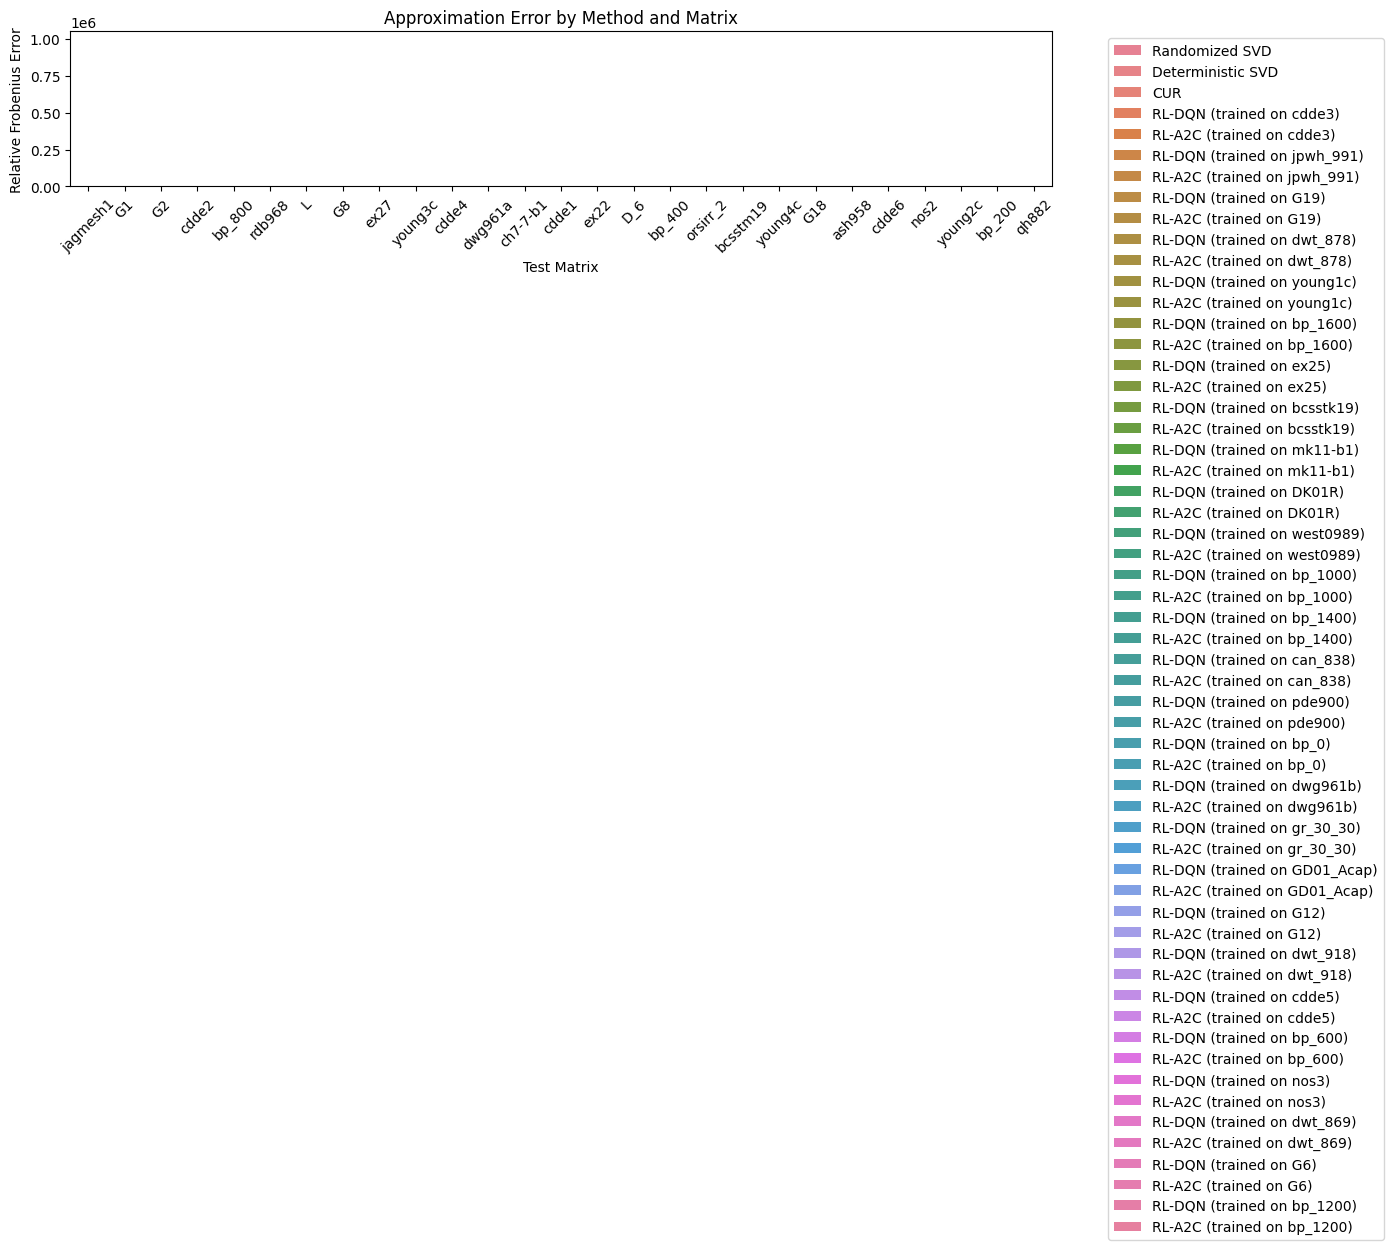

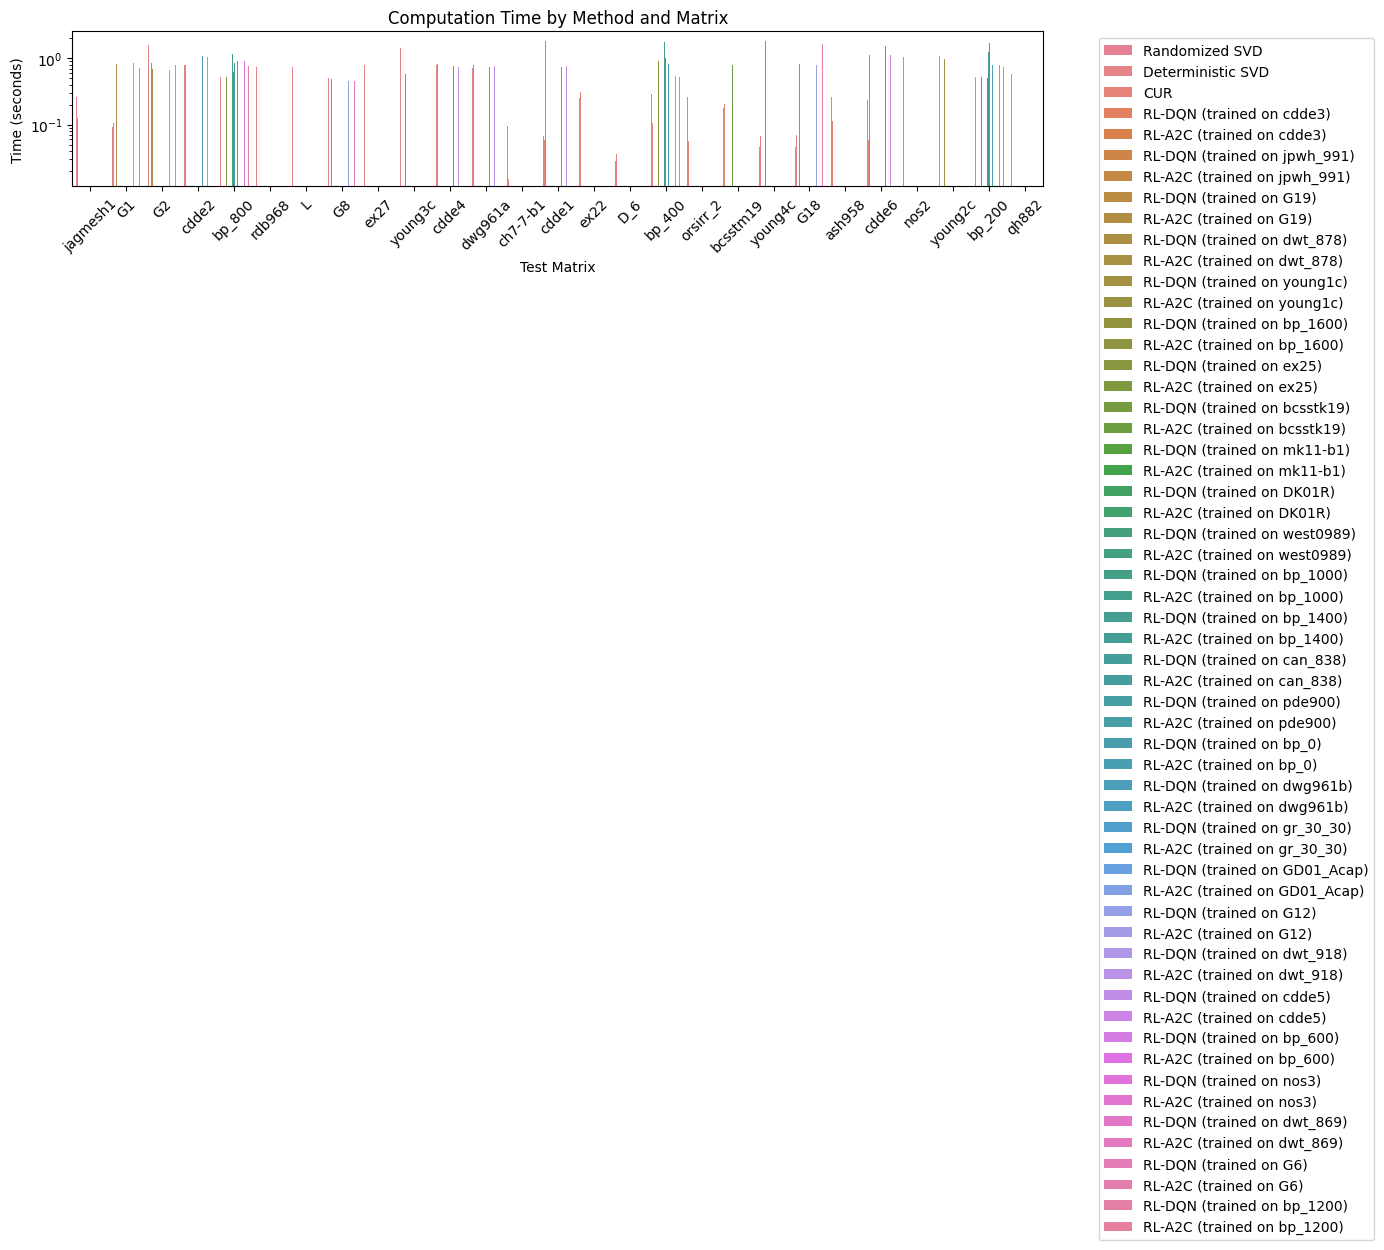

Florida matrix train/test experiments completed and results saved


In [ ]:
# # Set random seeds for reproducibility
# import numpy as np
# import os
# def set_random_seeds(seed=42):
#     """Set random seeds for reproducibility"""
#     import random
#     import torch

#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)

#     os.environ['PYTHONHASHSEED'] = str(seed)
# set_random_seeds(42)

# # Ensure directories exist
# os.makedirs("models", exist_ok=True)
# os.makedirs("results", exist_ok=True)

# # Run the experiment with train/test splitting
# results, train_matrices, test_matrices = florida_matrix_train_test_experiments()

# print("Florida matrix train/test experiments completed and results saved")

In [ ]:
# def save_load_florida_models(mode='save', agents=None, matrix_names=None):
#     """Save or load RL models for Florida matrices.

#     Parameters:
#     -----------
#     mode : str
#         'save' to save models, 'load' to load models
#     agents : dict
#         Dictionary of agents to save (only used in 'save' mode)
#     matrix_names : list
#         List of matrix names to load models for (only used in 'load' mode)

#     Returns:
#     --------
#     dict of loaded agents (only in 'load' mode)
#     """
#     # Create directory for models if it doesn't exist
#     os.makedirs("models/florida", exist_ok=True)

#     if mode == 'save' and agents is not None:
#         print("Saving RL models for Florida matrices...")

#         # Save DQN agents
#         if 'dqn' in agents:
#             for matrix_name, agent in agents['dqn'].items():
#                 model_path = f'models/florida/dqn_{matrix_name}.pt'
#                 torch.save(agent.q_network.state_dict(), model_path)
#                 print(f"DQN model for {matrix_name} saved to {model_path}")

#         # Save A2C agents
#         if 'a2c' in agents:
#             for matrix_name, agent in agents['a2c'].items():
#                 model_path = f'models/florida/a2c_{matrix_name}.pt'
#                 torch.save(agent.model.state_dict(), model_path)
#                 print(f"A2C model for {matrix_name} saved to {model_path}")

#         return True

#     elif mode == 'load' and matrix_names is not None:
#         print("Loading RL models for Florida matrices...")
#         loaded_agents = {'dqn': {}, 'a2c': {}}

#         # Load matrices first to determine dimensions for agent initialization
#         matrices = {}
#         for matrix_name in matrix_names:
#             try:
#                 matrix_path = f"florida_matrices/{matrix_name}.npz"
#                 if os.path.exists(matrix_path):
#                     A = load_florida_matrix(matrix_path)
#                     A = preprocess_florida_matrix(A)
#                     matrices[matrix_name] = A
#                     print(f"Loaded matrix {matrix_name} with shape {A.shape}")
#             except Exception as e:
#                 print(f"Error loading matrix {matrix_name}: {str(e)}")

#         # Load DQN agents
#         for matrix_name in matrix_names:
#             dqn_path = f'models/florida/dqn_{matrix_name}.pt'
#             if os.path.exists(dqn_path) and matrix_name in matrices:
#                 try:
#                     A = matrices[matrix_name]
#                     target_rank = 10  # Default rank

#                     # Initialize agent with correct dimensions
#                     env = ColumnSelectionEnv(A, target_rank)
#                     state_dim = env.n
#                     action_dim = env.n
#                     dqn_agent = DQNAgent(state_dim, action_dim)

#                     # Load weights
#                     dqn_agent.q_network.load_state_dict(torch.load(dqn_path))
#                     dqn_agent.target_network.load_state_dict(dqn_agent.q_network.state_dict())
#                     loaded_agents['dqn'][matrix_name] = dqn_agent
#                     print(f"Loaded DQN model for {matrix_name} from {dqn_path}")
#                 except Exception as e:
#                     print(f"Error loading DQN model for {matrix_name}: {str(e)}")

#         # Load A2C agents
#         for matrix_name in matrix_names:
#             a2c_path = f'models/florida/a2c_{matrix_name}.pt'
#             if os.path.exists(a2c_path) and matrix_name in matrices:
#                 try:
#                     A = matrices[matrix_name]
#                     target_rank = 10  # Default rank

#                     # Initialize agent with correct dimensions
#                     env = EnhancedColumnSelectionEnv(A, target_rank, state_type='combined', reward_type='combined')
#                     if env.state_type == 'combined':
#                         state_dim = env.n * 3  # Combined state has 3 channels
#                     else:
#                         state_dim = env.n
#                     action_dim = env.n
#                     a2c_agent = A2CAgent(state_dim, action_dim)

#                     # Load weights
#                     a2c_agent.model.load_state_dict(torch.load(a2c_path))
#                     loaded_agents['a2c'][matrix_name] = a2c_agent
#                     print(f"Loaded A2C model for {matrix_name} from {a2c_path}")
#                 except Exception as e:
#                     print(f"Error loading A2C model for {matrix_name}: {str(e)}")

#         return loaded_agents

#     else:
#         print("Invalid mode or missing required arguments.")
#         return None

In [ ]:
# def florida_matrix_experiments_with_model_saving():
#     """Run experiments with Florida matrices and save trained models"""
#     # Define matrices to download
#     matrix_info_list = [
#             {"id": 187, "name": "jpwh_991", "group": "HB"},
#     {"id": 2061, "name": "mk11-b1", "group": "JGD_Homology"},
#     {"id": 270, "name": "west0989", "group": "HB"},
#     {"id": 424, "name": "ex27", "group": "FIDAP"},
#     {"id": 2188, "name": "D_6", "group": "JGD_SL6"},
#     {"id": 333, "name": "rdb968", "group": "Bai"},
#     {"id": 300, "name": "cdde1", "group": "Bai"},
#     {"id": 304, "name": "cdde5", "group": "Bai"},
#     {"id": 1618, "name": "dwg961a", "group": "Bai"},
#     {"id": 305, "name": "cdde6", "group": "Bai"},
#     {"id": 1619, "name": "dwg961b", "group": "Bai"},
#     {"id": 302, "name": "cdde3", "group": "Bai"},
#     {"id": 301, "name": "cdde2", "group": "Bai"},
#     {"id": 303, "name": "cdde4", "group": "Bai"},
#     {"id": 219, "name": "nos3", "group": "HB"},
#     {"id": 12, "name": "ash958", "group": "HB"},
#     {"id": 218, "name": "nos2", "group": "HB"},
#     {"id": 2429, "name": "L", "group": "AG-Monien"},
#     {"id": 1478, "name": "GD01_Acap", "group": "Pajek"},

#     {"id": 2737, "name": "spaceStation_4", "group": "VDOL"},
#     {"id": 176, "name": "jagmesh1", "group": "HB"},
#     {"id": 138, "name": "dwt_918", "group": "HB"},
#     {"id": 2721, "name": "orbitRaising_4", "group": "VDOL"},
#     {"id": 2334, "name": "DK01R", "group": "Fluorem"},
#     {"id": 159, "name": "gr_30_30", "group": "HB"},
#     {"id": 325, "name": "pde900", "group": "Bai"},
#     {"id": 226, "name": "orsirr_2", "group": "HB"},
#     {"id": 328, "name": "qh882", "group": "Bai"},
#     {"id": 2027, "name": "ch7-7-b1", "group": "JGD_Homology"},
#     {"id": 137, "name": "dwt_878", "group": "HB"},
#     {"id": 135, "name": "dwt_869", "group": "HB"},
#     {"id": 2690, "name": "goddardRocketProblem_2", "group": "VDOL"},
#     {"id": 422, "name": "ex25", "group": "FIDAP"},
#     {"id": 2888, "name": "Vehicle_10NN", "group": "ML_Graph"},
#     {"id": 279, "name": "young2c", "group": "HB"},
#     {"id": 278, "name": "young1c", "group": "HB"},
#     {"id": 280, "name": "young3c", "group": "HB"},
#     {"id": 281, "name": "young4c", "group": "HB"},
#     {"id": 419, "name": "ex22", "group": "FIDAP"},

#     {"id": 107, "name": "can_838", "group": "HB"},
#     {"id": 2689, "name": "goddardRocketProblem", "group": "VDOL"},
#     {"id": 87, "name": "bp_200", "group": "HB"},
#     {"id": 88, "name": "bp_400", "group": "HB"},
#     {"id": 84, "name": "bp_1200", "group": "HB"},
#     {"id": 85, "name": "bp_1400", "group": "HB"},
#     {"id": 86, "name": "bp_1600", "group": "HB"},
#     {"id": 83, "name": "bp_1000", "group": "HB"},
#     {"id": 89, "name": "bp_600", "group": "HB"},
#     {"id": 82, "name": "bp_0", "group": "HB"},
#     {"id": 90, "name": "bp_800", "group": "HB"},
#     {"id": 69, "name": "bcsstm19", "group": "HB"},
#     {"id": 41, "name": "bcsstk19", "group": "HB"},
#     {"id": 479, "name": "G19", "group": "Gset"},
#     {"id": 480, "name": "G2", "group": "Gset"},
#     {"id": 469, "name": "G1", "group": "Gset"},
#     {"id": 478, "name": "G18", "group": "Gset"},
#     {"id": 524, "name": "G6", "group": "Gset"},
#     {"id": 534, "name": "G8", "group": "Gset"},
#     {"id": 472, "name": "G12", "group": "Gset"}
#     ]

#     # Download matrices
#     matrices = {}
#     for matrix_info in matrix_info_list:
#         matrix_id = matrix_info["id"]
#         matrix_name = matrix_info["name"]
#         group = matrix_info["group"]

#         print(f"Processing matrix {matrix_name}...")
#         matrix_path = download_matrix_from_ssmc(matrix_id, matrix_name, group)

#         if matrix_path:
#             try:
#                 # Load and preprocess the matrix
#                 A = load_florida_matrix(matrix_path)
#                 A = preprocess_florida_matrix(A)
#                 matrices[matrix_name] = A
#                 print(f"Loaded matrix {matrix_name} with shape {A.shape}")
#             except Exception as e:
#                 print(f"Error loading matrix {matrix_name}: {str(e)}")

#     # Define target rank for experiments
#     target_rank = 10

#     # Train RL agents on each matrix
#     dqn_agents = {}
#     a2c_agents = {}

#     for matrix_name, A in matrices.items():
#         print(f"\nTraining agents on {matrix_name} matrix...")

#         # Only try RL for matrices with reasonable number of columns
#         if A.shape[1] < 1000:
#             # Train DQN agent
#             try:
#                 env = ColumnSelectionEnv(A, target_rank)
#                 state_dim = env.n
#                 action_dim = env.n
#                 dqn_agent = DQNAgent(state_dim, action_dim)
#                 print(f"Training DQN agent for {matrix_name}...")
#                 train_dqn(dqn_agent, env, num_episodes=200)  # Fewer episodes for real matrices
#                 dqn_agents[matrix_name] = dqn_agent
#                 print(f"Completed DQN training for {matrix_name}")
#             except Exception as e:
#                 print(f"Error training DQN for {matrix_name}: {str(e)}")

#             # Train A2C agent
#             try:
#                 env = EnhancedColumnSelectionEnv(A, target_rank, state_type='combined', reward_type='combined')
#                 if env.state_type == 'combined':
#                     state_dim = env.n * 3  # Combined state has 3 channels
#                 else:
#                     state_dim = env.n
#                 action_dim = env.n
#                 a2c_agent = A2CAgent(state_dim, action_dim)
#                 print(f"Training A2C agent for {matrix_name}...")
#                 train_a2c(a2c_agent, env, num_episodes=200)  # Fewer episodes for real matrices
#                 a2c_agents[matrix_name] = a2c_agent
#                 print(f"Completed A2C training for {matrix_name}")
#             except Exception as e:
#                 print(f"Error training A2C for {matrix_name}: {str(e)}")

#     # Save trained models
#     print("\nSaving trained models...")
#     agents = {
#         'dqn': dqn_agents,
#         'a2c': a2c_agents
#     }
#     save_load_florida_models(mode='save', agents=agents)

#     # Run quick test to verify models were saved correctly
#     print("\nVerifying saved models...")
#     matrix_names = list(matrices.keys())
#     loaded_agents = save_load_florida_models(mode='load', matrix_names=matrix_names)

#     # Compare results
#     results = {}

#     for matrix_name, A in matrices.items():
#         print(f"\nTesting on {matrix_name}...")
#         results[matrix_name] = {}

#         # Test baseline methods
#         # Deterministic SVD
#         start = time.time()
#         Ar_det = deterministic_rank_approx(A, target_rank)
#         time_det = time.time() - start
#         err_det = np.linalg.norm(A - Ar_det, 'fro') / np.linalg.norm(A, 'fro')
#         results[matrix_name]['Deterministic SVD'] = {'error': err_det, 'time': time_det}
#         print(f"Deterministic SVD - Error: {err_det:.4f}, Time: {time_det:.4f}s")

#         # Randomized SVD
#         start = time.time()
#         Ar_rand = randomized_rank_approx(A, target_rank)
#         time_rand = time.time() - start
#         err_rand = np.linalg.norm(A - Ar_rand, 'fro') / np.linalg.norm(A, 'fro')
#         results[matrix_name]['Randomized SVD'] = {'error': err_rand, 'time': time_rand}
#         print(f"Randomized SVD - Error: {err_rand:.4f}, Time: {time_rand:.4f}s")

#         # Test RL methods if matrix is not too large
#         if A.shape[1] < 1000:
#             # Test with fresh-trained DQN agent
#             if matrix_name in dqn_agents:
#                 try:
#                     start = time.time()
#                     Ar_dqn, selected_cols = rl_column_selection_with_dqn(A, target_rank, dqn_agents[matrix_name])
#                     time_dqn = time.time() - start
#                     err_dqn = np.linalg.norm(A - Ar_dqn, 'fro') / np.linalg.norm(A, 'fro')
#                     results[matrix_name]['RL-DQN (fresh)'] = {'error': err_dqn, 'time': time_dqn}
#                     print(f"RL-DQN (fresh) - Error: {err_dqn:.4f}, Time: {time_dqn:.4f}s")
#                 except Exception as e:
#                     print(f"Error testing fresh DQN on {matrix_name}: {str(e)}")

#             # Test with loaded DQN agent
#             if matrix_name in loaded_agents['dqn']:
#                 try:
#                     start = time.time()
#                     Ar_dqn, selected_cols = rl_column_selection_with_dqn(A, target_rank, loaded_agents['dqn'][matrix_name])
#                     time_dqn = time.time() - start
#                     err_dqn = np.linalg.norm(A - Ar_dqn, 'fro') / np.linalg.norm(A, 'fro')
#                     results[matrix_name]['RL-DQN (loaded)'] = {'error': err_dqn, 'time': time_dqn}
#                     print(f"RL-DQN (loaded) - Error: {err_dqn:.4f}, Time: {time_dqn:.4f}s")
#                 except Exception as e:
#                     print(f"Error testing loaded DQN on {matrix_name}: {str(e)}")

#     # Save results
#     with open('results/florida_matrix_with_saving_results.pkl', 'wb') as f:
#         pickle.dump(results, f)

#     print("\nFlorida matrix experiments with model saving completed and results saved to 'results/florida_matrix_with_saving_results.pkl'")
#     return matrices, dqn_agents, a2c_agents, results

In [ ]:
# # Set random seeds for reproducibility
# set_random_seeds(42)

# # Ensure directories exist
# os.makedirs("models/florida", exist_ok=True)
# os.makedirs("results", exist_ok=True)

# # Run experiments with model saving
# matrices, dqn_agents, a2c_agents, results = florida_matrix_experiments_with_model_saving()

# print("\nExperiments complete! Models saved and verified.")